# Imports and data loading

In [1]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import xai

torch_device = helpers.utils.get_torch_device()

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
AVAILABLE_MODELS = ("ResNet50", "ConvNeXtSmall", "SwinTransformerSmall")
pd.options.display.precision = 5
pd.options.display.max_colwidth = 20

## Load data into multi-indexed dataframe

In [4]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            # adjust value in line with methodology formula and updated output_completeness.py
            df["output_completeness : preservation_check_conf_drop"] = 1 - df["output_completeness : preservation_check_conf_drop"]

            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables loaded
GradCAM: 12 tables loaded
KPCACAM: 12 tables loaded


In [5]:
# ew = pd.ExcelWriter("all_results_export.xlsx")
big_df_dict = dict()
for sheet_name, df_dict in dfs.items():
    temp_df = pd.concat(df_dict).reset_index()
    temp_df["dataset"] = temp_df["level_0"].str.split("_").str.get(0)
    temp_df["model"] = temp_df["level_0"].str.split("_").str.get(1)
    temp_df = temp_df.rename(columns={"level_1": "class_label"}).set_index(["dataset", "model", "class_label"]).drop(["level_0"], axis="columns")

    # temp_df.to_excel(ew, sheet_name=sheet_name, index=True, merge_cells=False)

    big_df_dict[sheet_name] = temp_df
# ew.close()

In [6]:
xai_ds_m_c_df = pd.concat(big_df_dict.values(), keys=big_df_dict.keys(), names=["xai_method"])
xai_ds_m_c_df = xai_ds_m_c_df.drop(
    columns=xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.startswith("continuity") | xai_ds_m_c_df.columns.str.endswith("l2_distance")]
)  # drop columns that are not being used for the analysis
xai_ds_m_c_df.columns = xai_ds_m_c_df.columns.str.replace("randomised_model_similarity", "random_sim").str.replace("adversarial_attack_similarity", "adv_attk_sim").str.replace("correctness", "COR").str.replace("output_completeness", "O-C").str.replace("contrastivity", "CON").str.replace("compactness", "COM").str.replace("spearman_rank", "SR").str.replace("top_k_intersection", "top_m").str.replace("structural_similarity", "ssim")
xai_ds_m_c_df = xai_ds_m_c_df.replace(-np.inf, np.nan)
xai_ds_m_c_df.columns, xai_ds_m_c_df.index[-1]

(Index(['COR : random_sim : SR', 'COR : random_sim : top_m',
        'COR : random_sim : ssim', 'COR : incremental_deletion_auc_ratio',
        'O-C : deletion_check_conf_drop', 'O-C : preservation_check_conf_drop',
        'CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m',
        'CON : adv_attk_sim : ssim', 'COM : threshold_score'],
       dtype='object'),
 ('KPCACAM', 'UCMerced', 'SwinTransformerSmall', 'tenniscourt'))

In [7]:
xai_ds_m_c_df.head(10)

COR : random_sim : SR  \
xai_method    dataset   model         class_label                                   
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523     
                                      Forest                           -0.07230     
                                      HerbaceousVegetation             -0.04666     
                                      Highway                          -0.10270     
                                      Industrial                        0.02080     
                                      Pasture                          -0.08098     
                                      PermanentCrop                     0.01643     
                                      Residential                      -0.01304     
                                      River                             0.08319     
                                      SeaLake                           0.13131     

                                                            COR : random_sim : top_m  \
xai_method    dataset   model         class_label                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.14878        
                                      Forest                            0.07800        
                                      HerbaceousVegetation              0.10900        
                                      Highway                           0.10998        
                                      Industrial                        0.12305        
                                      Pasture                           0.13545        
                                      PermanentCrop                     0.12518        
                                      Residential                       0.08723        
                                      River                             0.24618        
                                      SeaLake                           0.19157        

                                                            COR : random_sim : ssim  \
xai_method    dataset   model         class_label                                     
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.41432       
                                      Forest                            0.40101       
                                      HerbaceousVegetation              0.39492       
                                      Highway                           0.37283       
                                      Industrial                        0.39885       
                                      Pasture                           0.38855       
                                      PermanentCrop                     0.39428       
                                      Residential                       0.37242       
                                      River                             0.44647       
                                      SeaLake                           0.44517       

                                                            COR : incremental_deletion_auc_ratio  \
xai_method    dataset   model         class_label                                                  
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.96003                    
                                      Forest                            0.99792                    
                                      HerbaceousVegetation              0.90204                    
                                      Highway                           0.21928                    
                                      Industrial                        0.57631                    
                                      Pasture                           0.77756                    
                                      PermanentCrop                     0.60866                    
                                     

# Sanity check correctness (random_sim)

We want this to be low across all 3 similarity metrics if the explanation accurately reflects the model's behaviour.

In [8]:
cor_rs_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : random_sim")]
cor_rs_df: pd.DataFrame = xai_ds_m_c_df[cor_rs_cols].copy()
cor_rs_df["COR : random_sim : SR"] = cor_rs_df["COR : random_sim : SR"].abs()
cor_rs_df.head(10)

COR : random_sim : SR  \
xai_method    dataset   model         class_label                                   
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523     
                                      Forest                            0.07230     
                                      HerbaceousVegetation              0.04666     
                                      Highway                           0.10270     
                                      Industrial                        0.02080     
                                      Pasture                           0.08098     
                                      PermanentCrop                     0.01643     
                                      Residential                       0.01304     
                                      River                             0.08319     
                                      SeaLake                           0.13131     

                                                            COR : random_sim : top_m  \
xai_method    dataset   model         class_label                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.14878        
                                      Forest                            0.07800        
                                      HerbaceousVegetation              0.10900        
                                      Highway                           0.10998        
                                      Industrial                        0.12305        
                                      Pasture                           0.13545        
                                      PermanentCrop                     0.12518        
                                      Residential                       0.08723        
                                      River                             0.24618        
                                      SeaLake                           0.19157        

                                                            COR : random_sim : ssim  
xai_method    dataset   model         class_label                                    
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.41432      
                                      Forest                            0.40101      
                                      HerbaceousVegetation              0.39492      
                                      Highway                           0.37283      
                                      Industrial                        0.39885      
                                      Pasture                           0.38855      
                                      PermanentCrop                     0.39428      
                                      Residential                       0.37242      
                                      River                             0.44647      
                                      SeaLake                           0.44517

<Axes: xlabel='xai_method,dataset'>

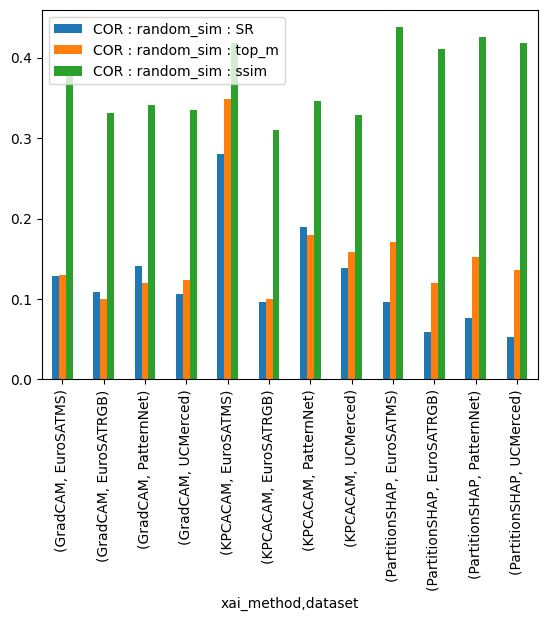

In [9]:
cor_rs_df.groupby(level=["xai_method", "dataset"]).mean().plot(kind="bar")

KPCA seems suspicious here on EuroSATMS

<Axes: xlabel='model'>

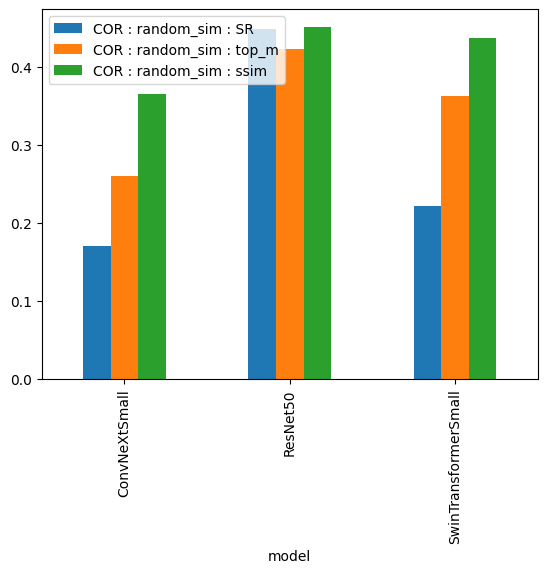

In [10]:
cor_rs_df.loc["KPCACAM", "EuroSATMS"].groupby("model").mean().plot(kind="bar")

Suggests that KPCACAM is not a faithful explainer for ResNet50 on EuroSATMS.

In [59]:
def colour_code_high_bars(threshold):
    ax = plt.gca()

    ax.axhline(threshold, color="r", linestyle="--")

    # Get all bar containers in the current plot
    containers = [c for c in ax.containers]
    heights = [p.get_height() for c in containers for p in c.patches]

    for container in containers:
        for patch in container.patches:
            height = patch.get_height()
            if height > threshold:
                # Calculate intensity based on how much it exceeds the threshold
                # Capping at 0.9 to avoid completely black bars
                ratio = max((height - threshold) / (max(heights) - threshold), 0.2)
                # Create a darker shade of red the higher the value
                color = (1.0, 1.0 - ratio, 1.0 - ratio)
                patch.set_facecolor(color)

# Correctness (incremental_deletion_auc_ratio)

We want this to be low (but might vary a lot by dataset and classes depending on object/land type) with 0 best and above 1 means random deletion was better.

In [80]:
cor_id_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : incremental_deletion_auc_ratio")]
cor_id_df: pd.DataFrame = xai_ds_m_c_df[cor_id_cols]
cor_id_df.columns

Index(['COR : incremental_deletion_auc_ratio'], dtype='object')

### Hardest dataset classes

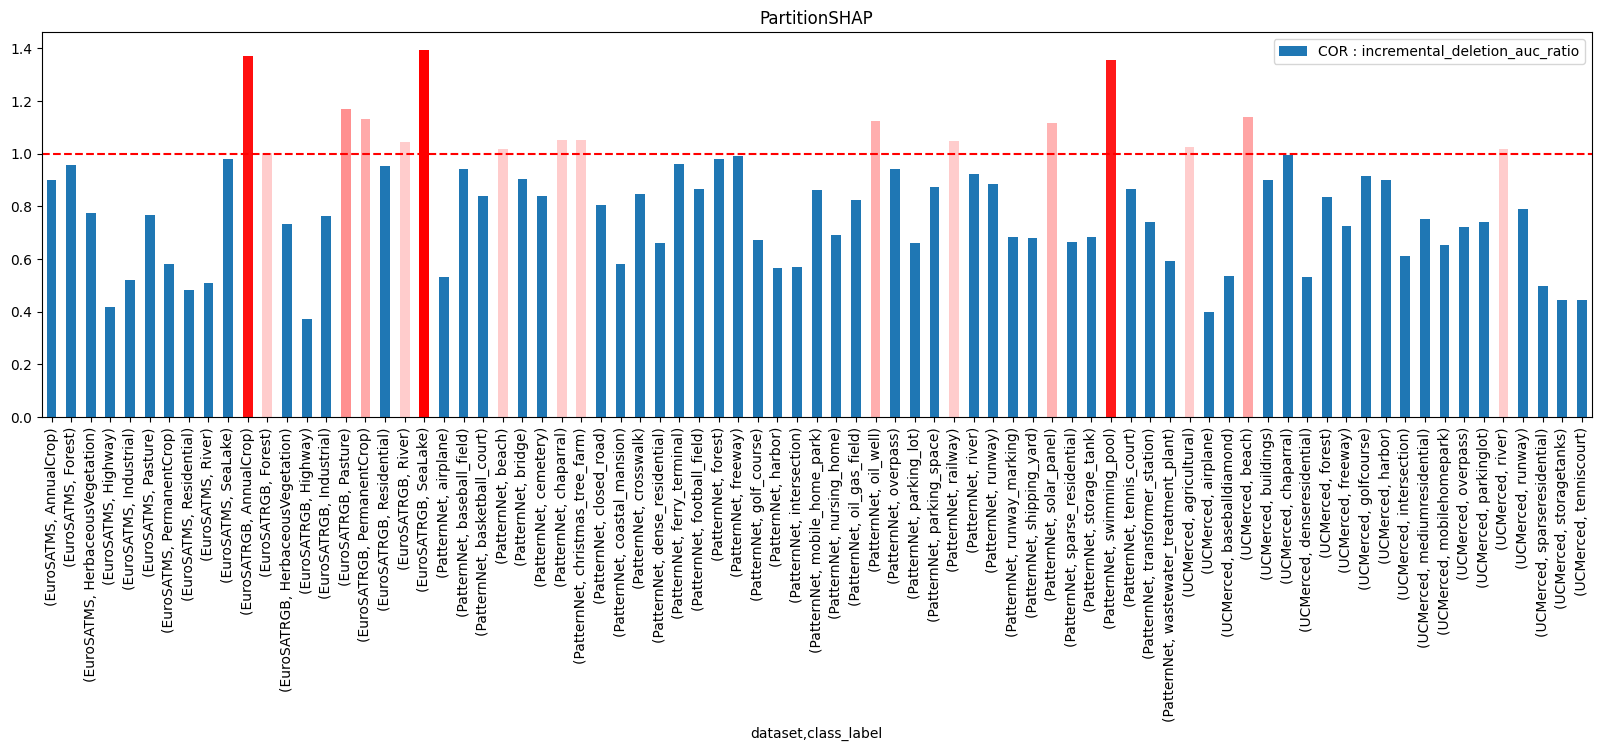

In [70]:
cor_id_df.loc["PartitionSHAP"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5), title="PartitionSHAP")
colour_code_high_bars(1)

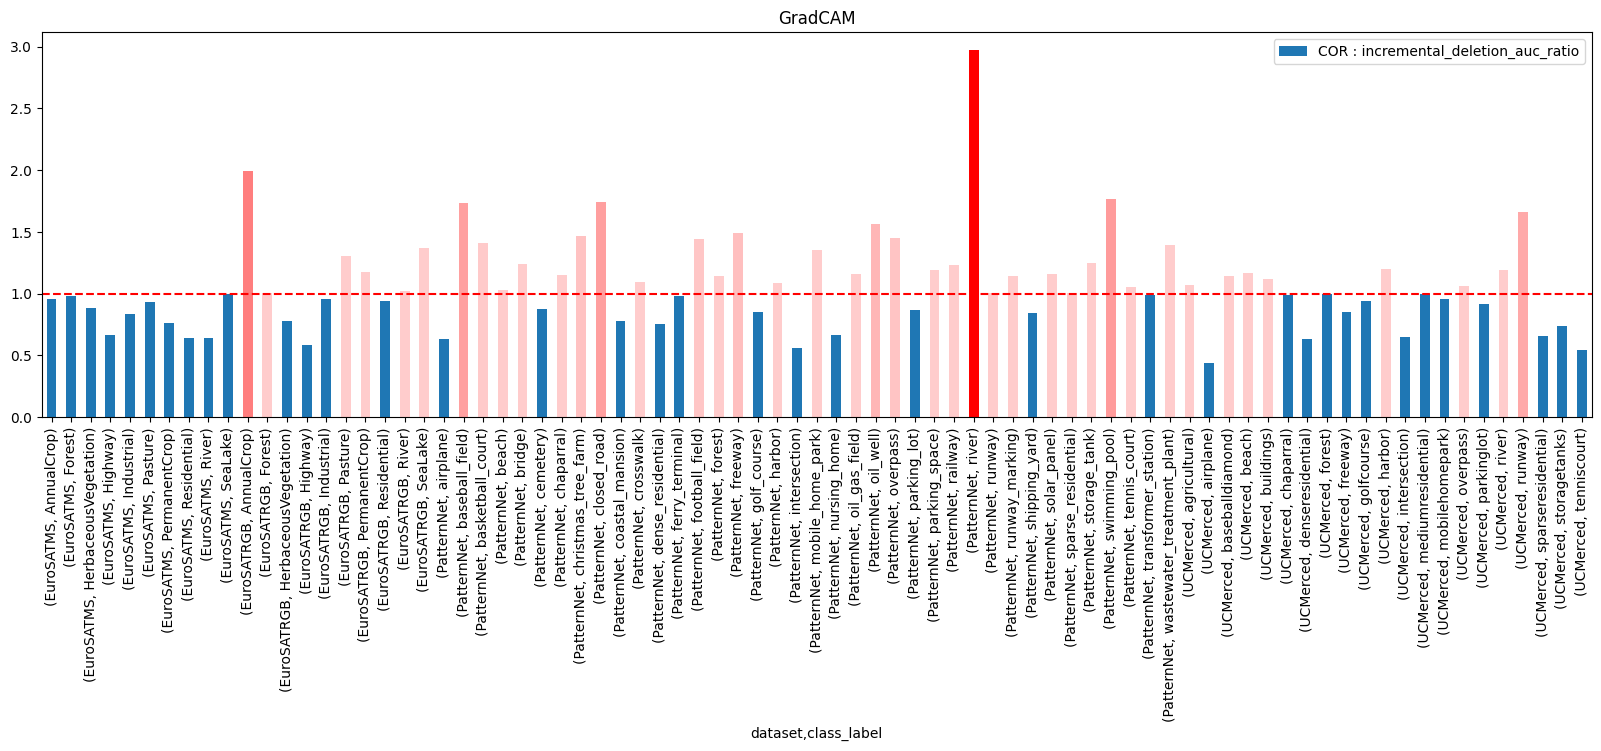

In [69]:
cor_id_df.loc["GradCAM"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5), title="GradCAM")
colour_code_high_bars(1)

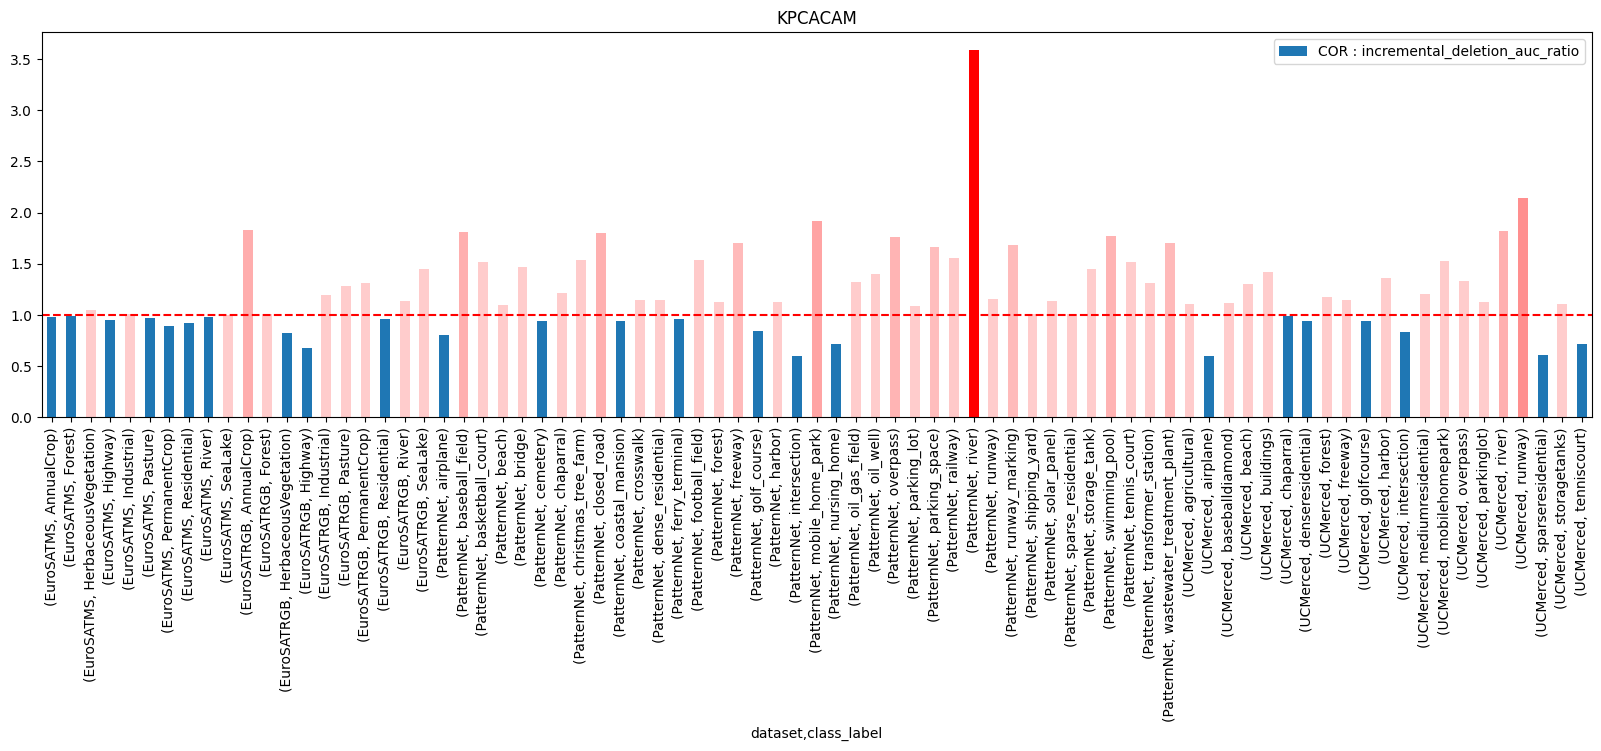

In [71]:
cor_id_df.loc["KPCACAM"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5), title="KPCACAM")
colour_code_high_bars(1)

In [40]:
cor_id_df.groupby(level=["dataset", "class_label"]).describe()

COR : incremental_deletion_auc_ratio           \
                                                              count     mean   
dataset   class_label                                                          
EuroSATMS AnnualCrop                            9.0                  0.94638   
          Forest                                9.0                  0.97582   
          HerbaceousVegetation                  9.0                  0.90223   
          Highway                               9.0                  0.67578   
          Industrial                            9.0                  0.78907   
...                                             ...                      ...   
UCMerced  river                                 9.0                  1.34108   
          runway                                9.0                  1.53043   
          sparseresidential                     9.0                  0.58711   
          storagetanks                          9.0                  0.76208   
          tenniscourt                           9.0                  0.56863   

                                                                             \
                                    std      min      25%      50%      75%   
dataset   class_label                                                         
EuroSATMS AnnualCrop            0.06166  0.80421  0.93998  0.96003  0.97477   
          Forest                0.03776  0.88898  0.97017  0.99416  0.99956   
          HerbaceousVegetation  0.14696  0.66195  0.81273  0.90204  0.99056   
          Highway               0.29700  0.21928  0.48018  0.78348  0.91618   
          Industrial            0.25730  0.47174  0.57631  0.76068  1.03202   
...                                 ...      ...      ...      ...      ...   
UCMerced  river                 0.80365  0.71815  0.83107  1.17202  1.36409   
          runway                0.99336  0.54190  0.59246  1.22958  2.20050   
          sparseresidential     0.25138  0.33335  0.38980  0.46014  0.78256   
          storagetanks          0.38258  0.34470  0.55187  0.59911  1.06751   
          tenniscourt           0.20593  0.32766  0.47225  0.49591  0.66484   

                                         
                                    max  
dataset   class_label                    
EuroSATMS AnnualCrop            1.00353  
          Forest                1.00114  
          HerbaceousVegetation  1.16035  
          Highway               1.00576  
          Industrial            1.19147  
...                                 ...  
UCMerced  river                 3.30575  
          runway                3.30330  
          sparseresidential     1.02730  
          storagetanks          1.47452  
          tenniscourt           0.98499  

[79 rows x 8 columns]

In EuroSATMS, SeaLake was the hardest class to delete important pixels (many adversarial examples also moved to this class) - makes sense: large area with similar colours. But also generally did well in MS across the board.

In EuroSATRGB: AnnualCrop, likely for similar reasons. Pasture and Permanent Crop also.

PatternNet: river the hardest but specifically for CAM methods. PartitionSHAP didn't struggle to identify. Swimming pool also hard for all.

UCMerced: runway and river (and to some extent beach).

## Are the other two good for any datasets at all?

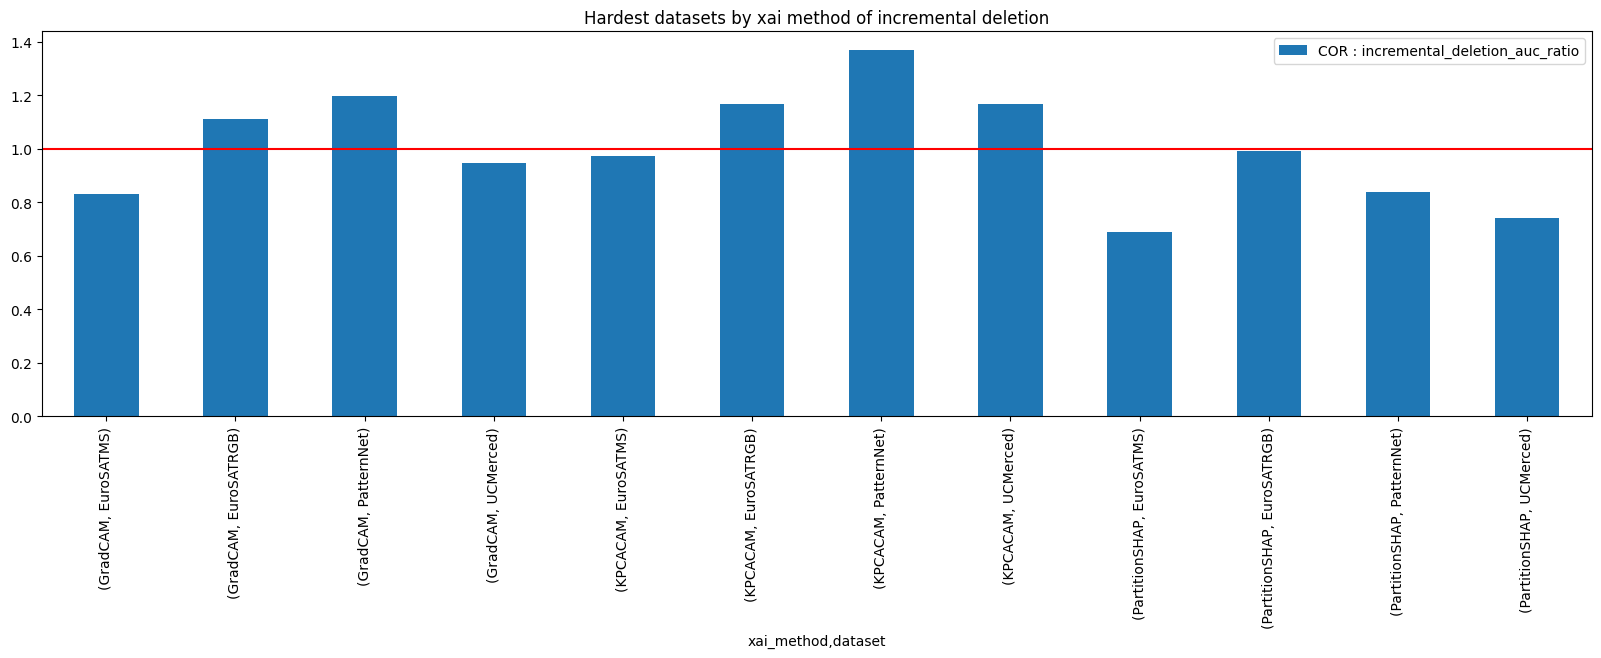

In [65]:
cor_id_df.groupby(["xai_method", "dataset"]).mean().plot(kind="bar", figsize=(20, 5), title="Hardest datasets by xai method of incremental deletion")
plt.axhline(1, color="r")

PatternNet was the hardest for GradCAM and KPCACAM with only PartitionSHAP getting sub 1 across all datasets.

In [17]:
cor_id_df.groupby(["xai_method", "dataset"]).describe()

COR : incremental_deletion_auc_ratio           \
                                                        count     mean   
xai_method    dataset                                                    
GradCAM       EuroSATMS                  30.0                  0.82994   
              EuroSATRGB                 30.0                  1.11285   
              PatternNet                114.0                  1.19767   
              UCMerced                   63.0                  0.94859   
KPCACAM       EuroSATMS                  30.0                  0.97277   
              EuroSATRGB                 30.0                  1.16655   
              PatternNet                114.0                  1.36977   
              UCMerced                   63.0                  1.16656   
PartitionSHAP EuroSATMS                  30.0                  0.68926   
              EuroSATRGB                 30.0                  0.99250   
              PatternNet                114.0                  0.83876   
              UCMerced                   63.0                  0.74126   

                                                                                
                              std      min      25%      50%      75%      max  
xai_method    dataset                                                           
GradCAM       EuroSATMS   0.17327  0.45930  0.70656  0.89276  0.96929  1.06780  
              EuroSATRGB  0.60779  0.28518  0.81591  0.99190  1.33768  3.44704  
              PatternNet  0.81778  0.36703  0.69203  0.89959  1.45060  5.98357  
              UCMerced    0.43346  0.33335  0.66329  0.84833  1.06849  2.45857  
KPCACAM       EuroSATMS   0.09761  0.74759  0.94474  0.99080  1.00468  1.19147  
              EuroSATRGB  0.57141  0.30470  0.90431  1.00399  1.34805  3.33477  
              PatternNet  0.92951  0.36664  0.83759  0.98808  1.52479  6.35402  
              UCMerced    0.61853  0.33906  0.82170  0.98476  1.28504  3.30575  
PartitionSHAP EuroSATMS   0.23960  0.21928  0.52181  0.70970  0.91071  0.99972  
              EuroSATRGB  0.44885  0.26239  0.63781  0.95733  1.19169  2.02407  
              PatternNet  0.33836  0.25907  0.58642  0.79110  1.02910  2.51742  
              UCMerced    0.26929  0.29997  0.55163  0.72084  0.95354  1.36409

All methods seem better than random for EuroSATMS deletion. PatternNet is hard for GradCAM and KPCACAM.

## Or good for any models?

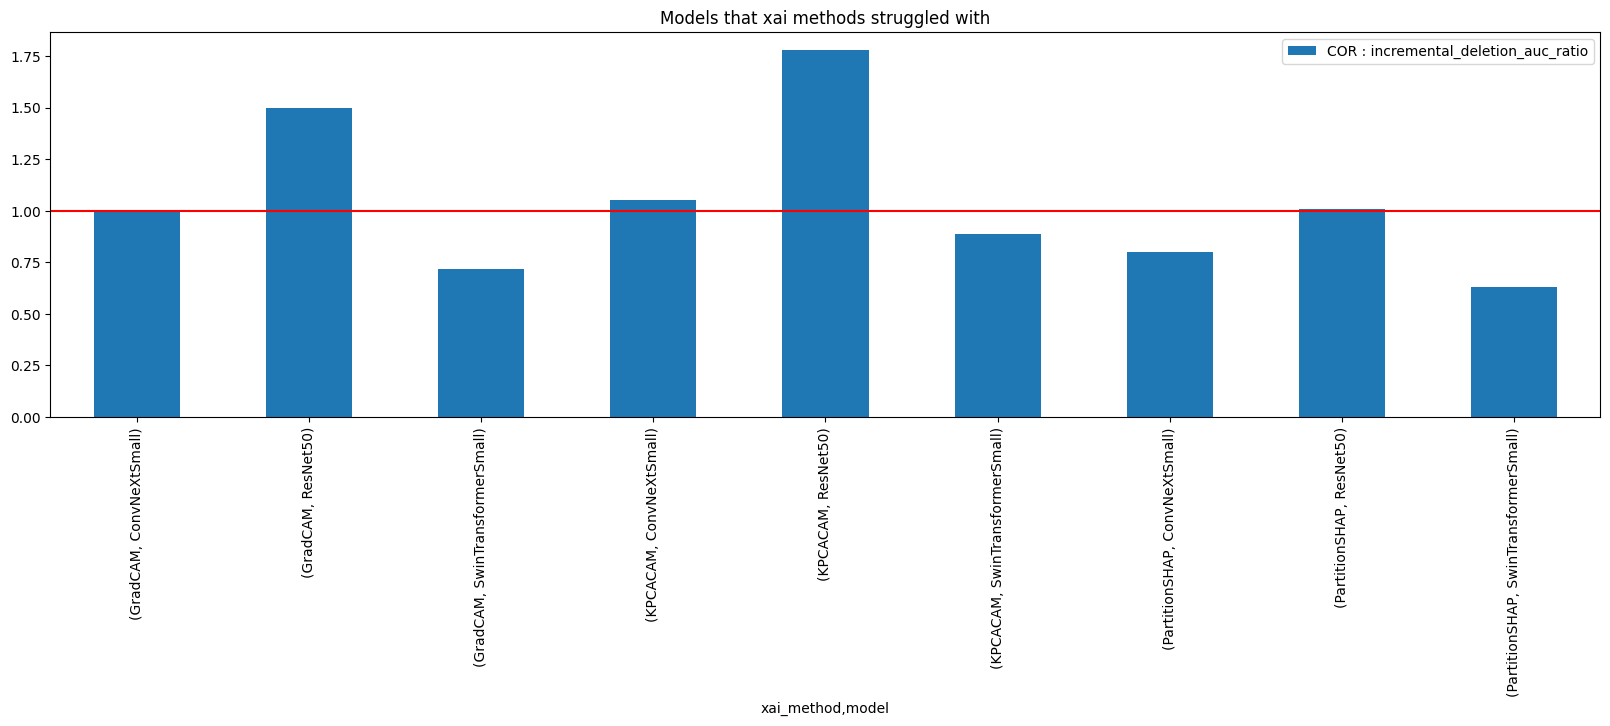

In [66]:
cor_id_df.groupby(["xai_method", "model"]).mean().plot(kind="bar", figsize=(20, 5), title="Models that xai methods struggled with")
plt.axhline(1, color="r")

In [18]:
cor_id_df.groupby(["xai_method", "model"]).describe()

COR : incremental_deletion_auc_ratio  \
                                                                  count   
xai_method    model                                                       
GradCAM       ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   
KPCACAM       ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   
PartitionSHAP ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   

                                                                        \
                                       mean      std      min      25%   
xai_method    model                                                      
GradCAM       ConvNeXtSmall         1.00323  0.67785  0.33335  0.68258   
              ResNet50              1.49967  0.71879  0.36703  0.93292   
              SwinTransformerSmall  0.71962  0.18251  0.28518  0.57146   
KPCACAM       ConvNeXtSmall         1.05277  0.71095  0.33906  0.76556   
              ResNet50              1.77783  0.86767  0.38608  1.01619   
              SwinTransformerSmall  0.88873  0.16578  0.30470  0.83230   
PartitionSHAP ConvNeXtSmall         0.80129  0.33443  0.21928  0.58900   
              ResNet50              1.00639  0.34377  0.49901  0.77030   
              SwinTransformerSmall  0.63245  0.20518  0.24977  0.50383   

                                                               
                                        50%      75%      max  
xai_method    model                                            
GradCAM       ConvNeXtSmall         0.93757  1.07644  5.98357  
              ResNet50              1.41777  1.85434  3.58557  
              SwinTransformerSmall  0.70991  0.85114  1.02511  
KPCACAM       ConvNeXtSmall         0.98005  1.16459  6.35402  
              ResNet50              1.60475  2.44378  4.07367  
              SwinTransformerSmall  0.92686  0.98800  1.25877  
PartitionSHAP ConvNeXtSmall         0.75182  0.98680  1.90917  
              ResNet50              0.98186  1.22673  2.51742  
              SwinTransformerSmall  0.59518  0.77912  1.01339

All are actually worst for ResNet with the highest mean and std (can also be seen in graph above)?? Especially for GradCAM and KPCACAM.
And consistently (low std) best on the SwinTransformer with by far the least bad worst case.

## Overall reliability

In [87]:
cor_id_df.groupby("xai_method").describe()

COR : incremental_deletion_auc_ratio                             \
                                             count     mean      std      min   
xai_method                                                                      
GradCAM                      237.0                  1.07417  0.66182  0.28518   
KPCACAM                      237.0                  1.23978  0.75818  0.30470   
PartitionSHAP                237.0                  0.81338  0.33677  0.21928   

                                                   
                   25%      50%      75%      max  
xai_method                                         
GradCAM        0.68965  0.89988  1.21619  5.98357  
KPCACAM        0.84281  0.99002  1.34524  6.35402  
PartitionSHAP  0.56973  0.76061  0.99408  2.51742

PartitionSHAP is the most reliable with a sub 1 incremental deletion ratio and lowest std. The UQ (75%) is also < 1.

In [88]:
cor_id_df[cor_id_df>=1].groupby("xai_method").count() / len(cor_id_df.loc["PartitionSHAP"])

COR : incremental_deletion_auc_ratio
xai_method                                         
GradCAM                    0.34177                 
KPCACAM                    0.45148                 
PartitionSHAP              0.22785

KPCACAM is only slightly better than random overall at identifying important pixels.

# Output-Completeness (deletion_check_conf_drop & preservation_check_conf_drop)

We want this to be high with the best score being 1. Worst possible in both cases is -1.

In [83]:
oc_dp_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("O-C")]
oc_dp_df: pd.DataFrame = xai_ds_m_c_df[oc_dp_cols].rename(columns={"O-C : deletion_check_conf_drop": "Del", "O-C : preservation_check_conf_drop": "Pres"})
oc_dp_df.columns

Index(['Del', 'Pres'], dtype='object')

GradCAM          Axes(0.1,0.15;0....
KPCACAM          Axes(0.382353,0....
PartitionSHAP    Axes(0.664706,0....
dtype: object

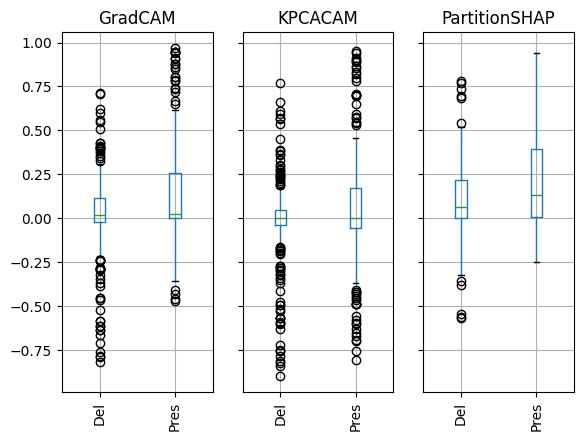

In [84]:
oc_dp_df.groupby("xai_method").boxplot(rot=90, subplots=True, layout=(1, 3))

On average, all are bad with a lot of variability. PartitionSHAP is slightly better.

Text(0.5, 0.98, 'Hard classes for all explainers on all models')

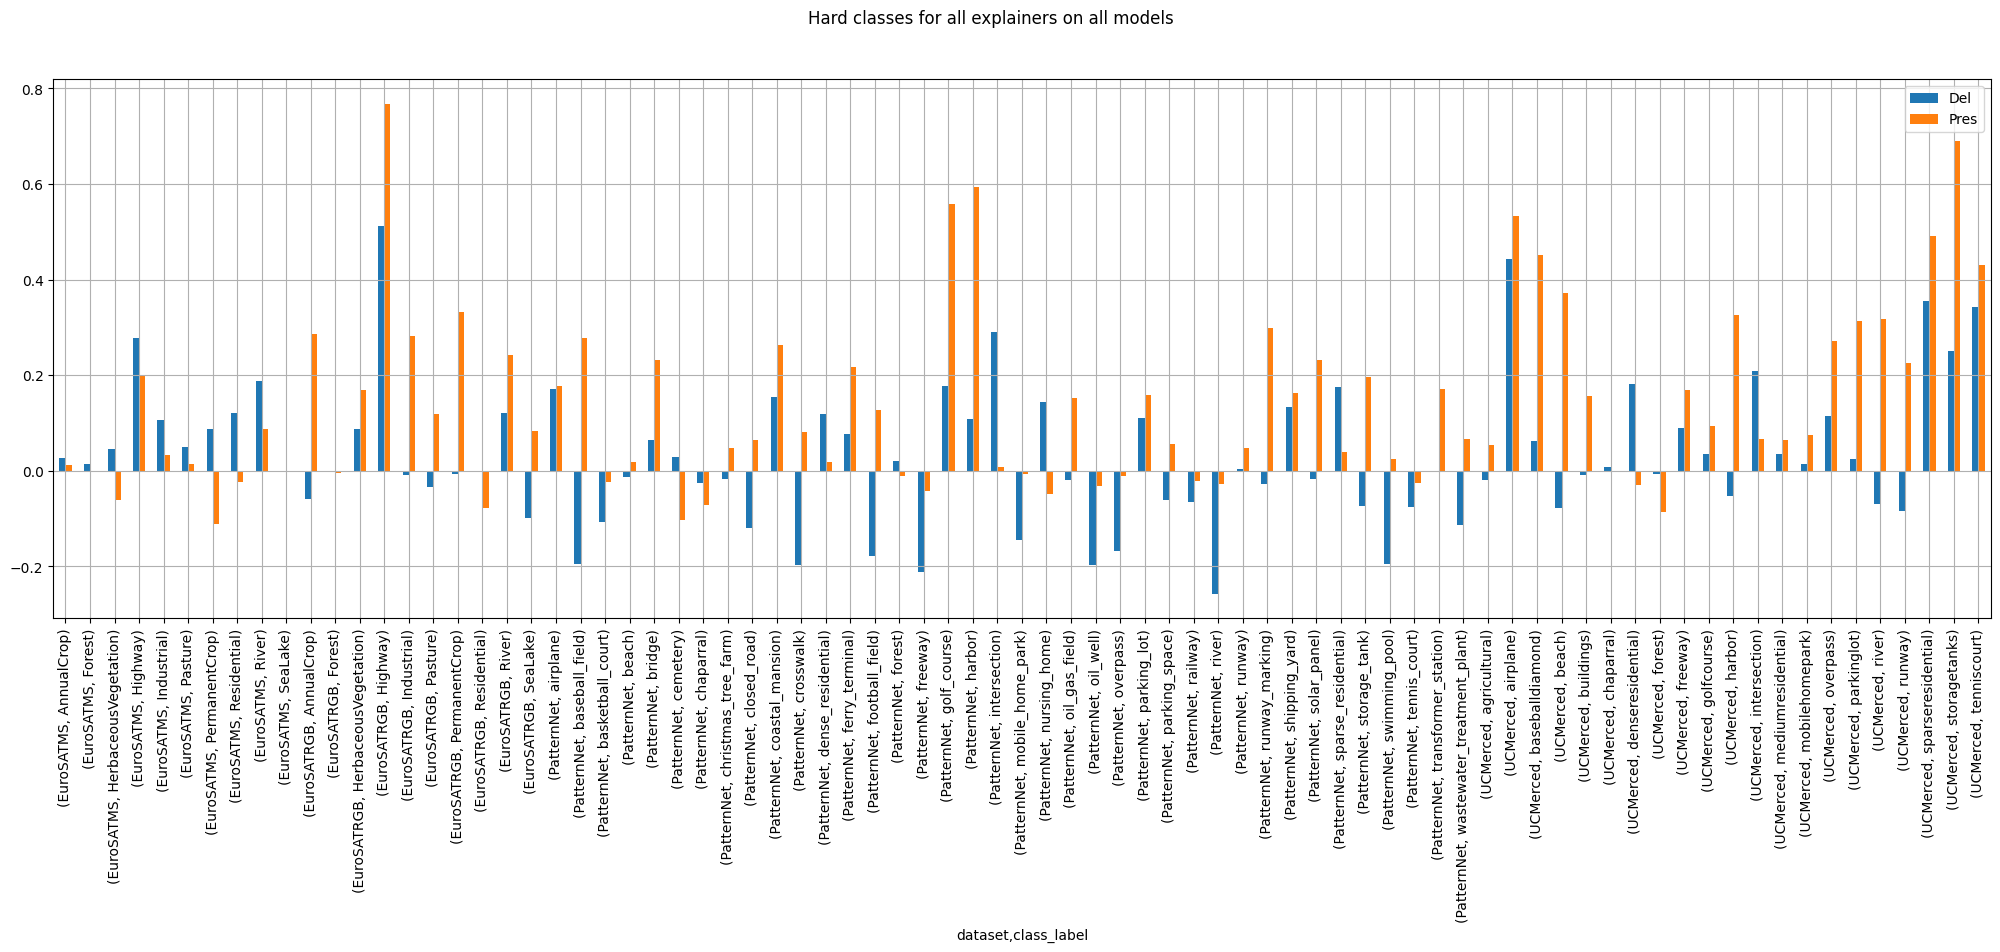

In [169]:
oc_dp_df_by_class_mean = oc_dp_df.groupby(["dataset", "class_label"]).mean()
oc_dp_df_by_class_mean.plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("Hard classes for all explainers on all models")

The easiest classes across the datasets to delete pixels from are EuroSAT-highway, PatternNet-intersection, UCM-airplane, sparse residential, storage tanks, and tennis court.
Perhaps because these are scenes where objects are localised to specific areas where important pixels can be easily deleted. In other classes, nearest neighbour in filling might result in such similar colours that the model still believes them to be present.

PatternNet's freeway, baseball field and river classes are very hard to delete though.

For preserving pixels, EuroSAT-highway remains easy, PatternNet-golf course and harbour, UCM-airplane, baseball diamond, beach, sparse residential, storage tanks and tennis court.
Since the surroundings are important for these as well, we theorise that classes can more easily change if these surrounding pixels are deleted.

## Investigate performance class by class for each explainer

Text(0.5, 0.98, 'GradCAM')

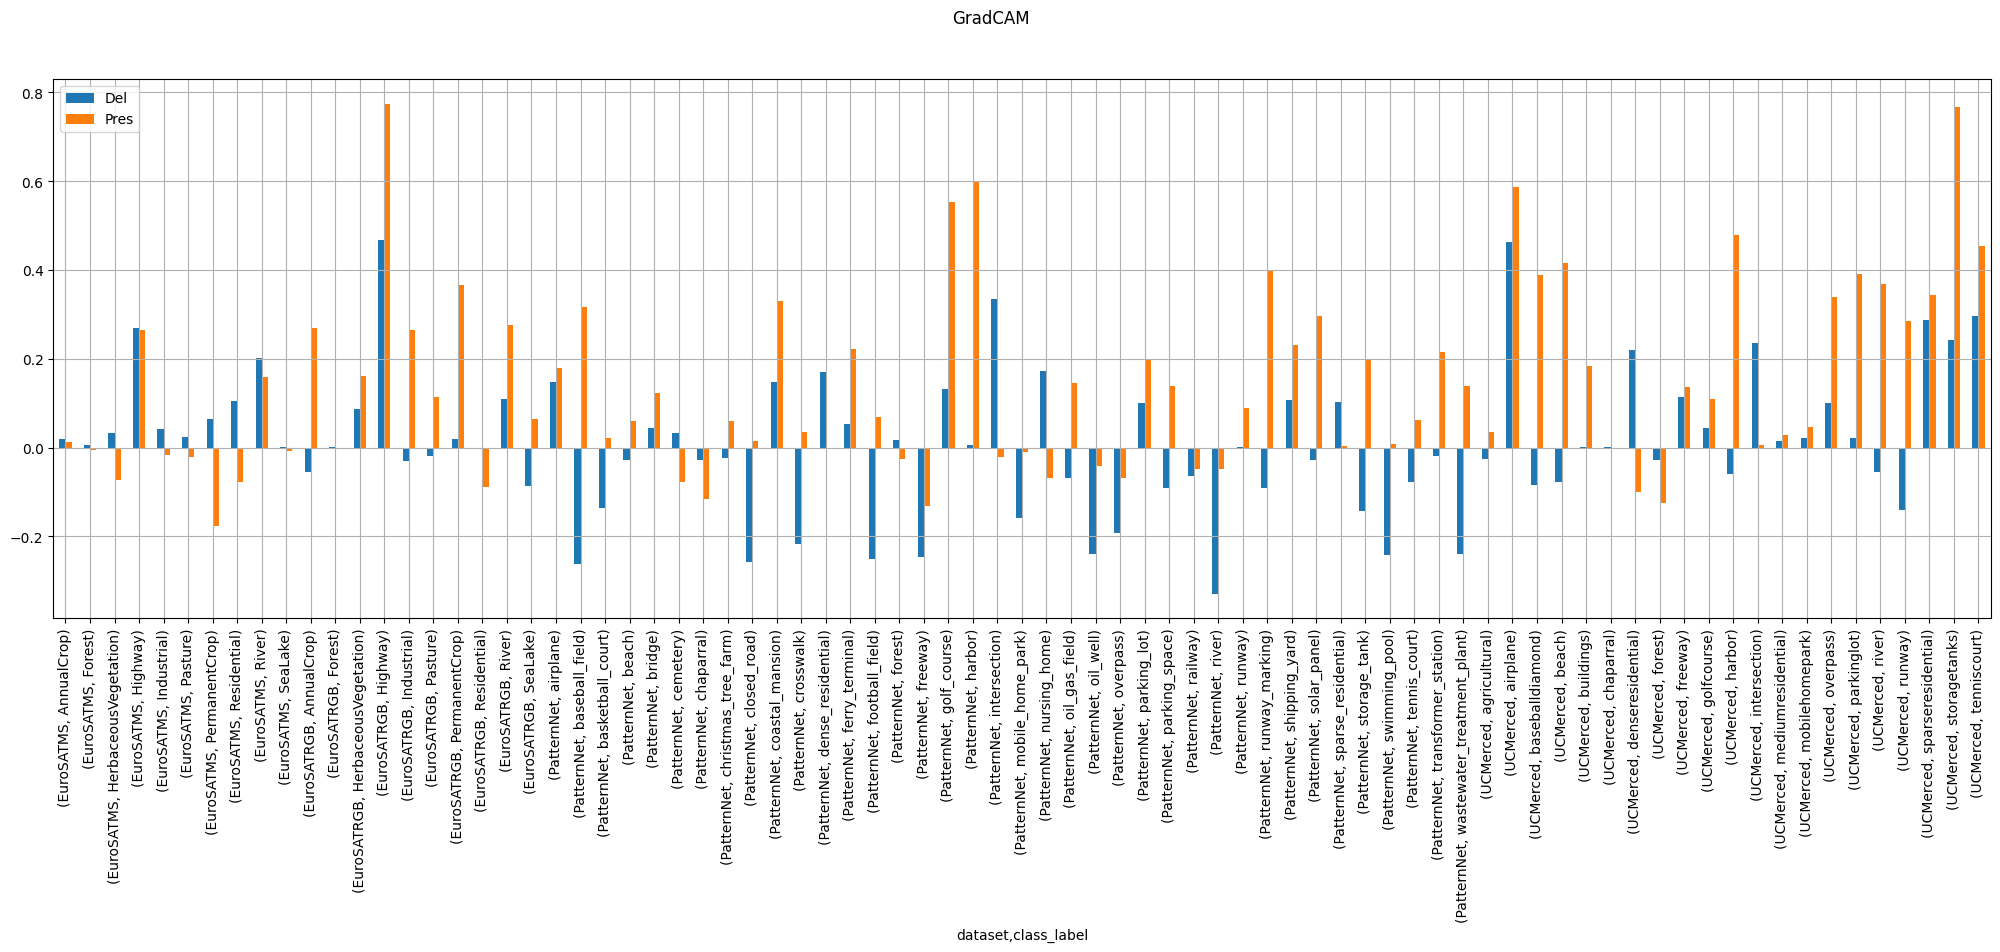

In [147]:
oc_dp_df.loc["GradCAM"].groupby(["dataset", "class_label"]).mean().plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("GradCAM")

Text(0.5, 0.98, 'KPCACAM')

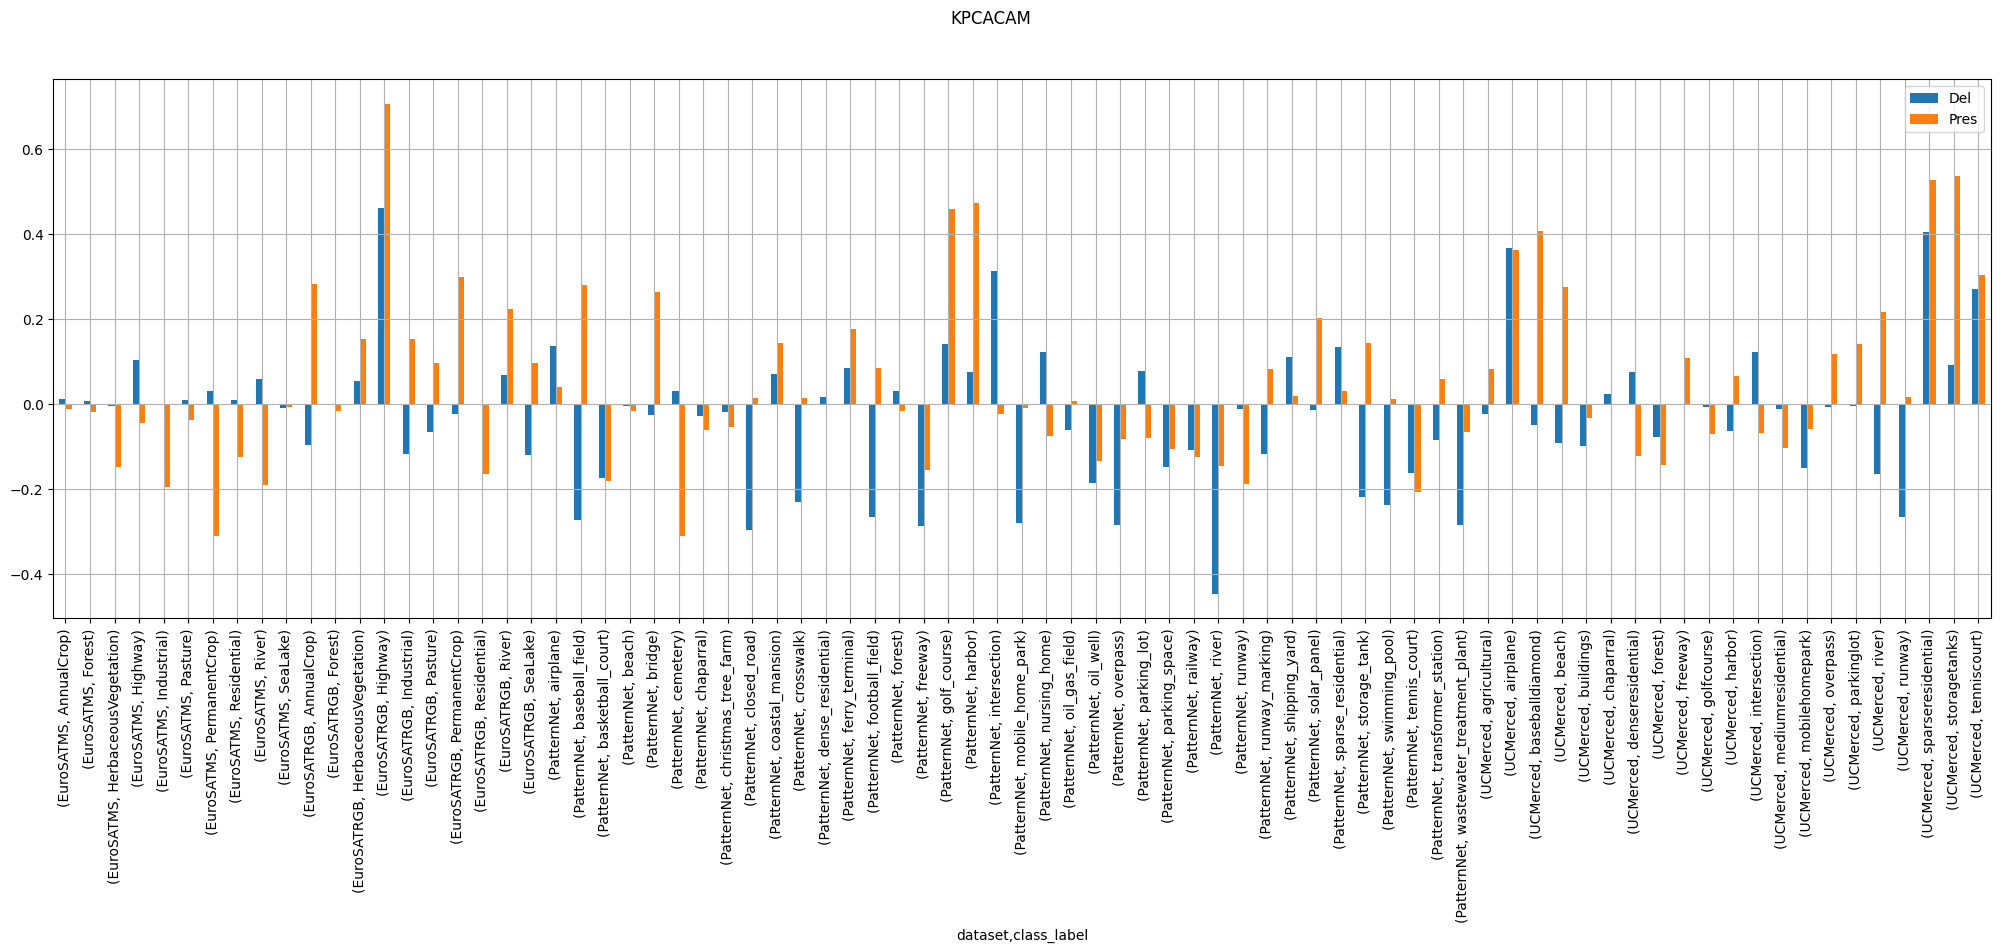

In [148]:
oc_dp_df.loc["KPCACAM"].groupby(["dataset", "class_label"]).mean().plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("KPCACAM")

Text(0.5, 0.98, 'KPCACAM - average')

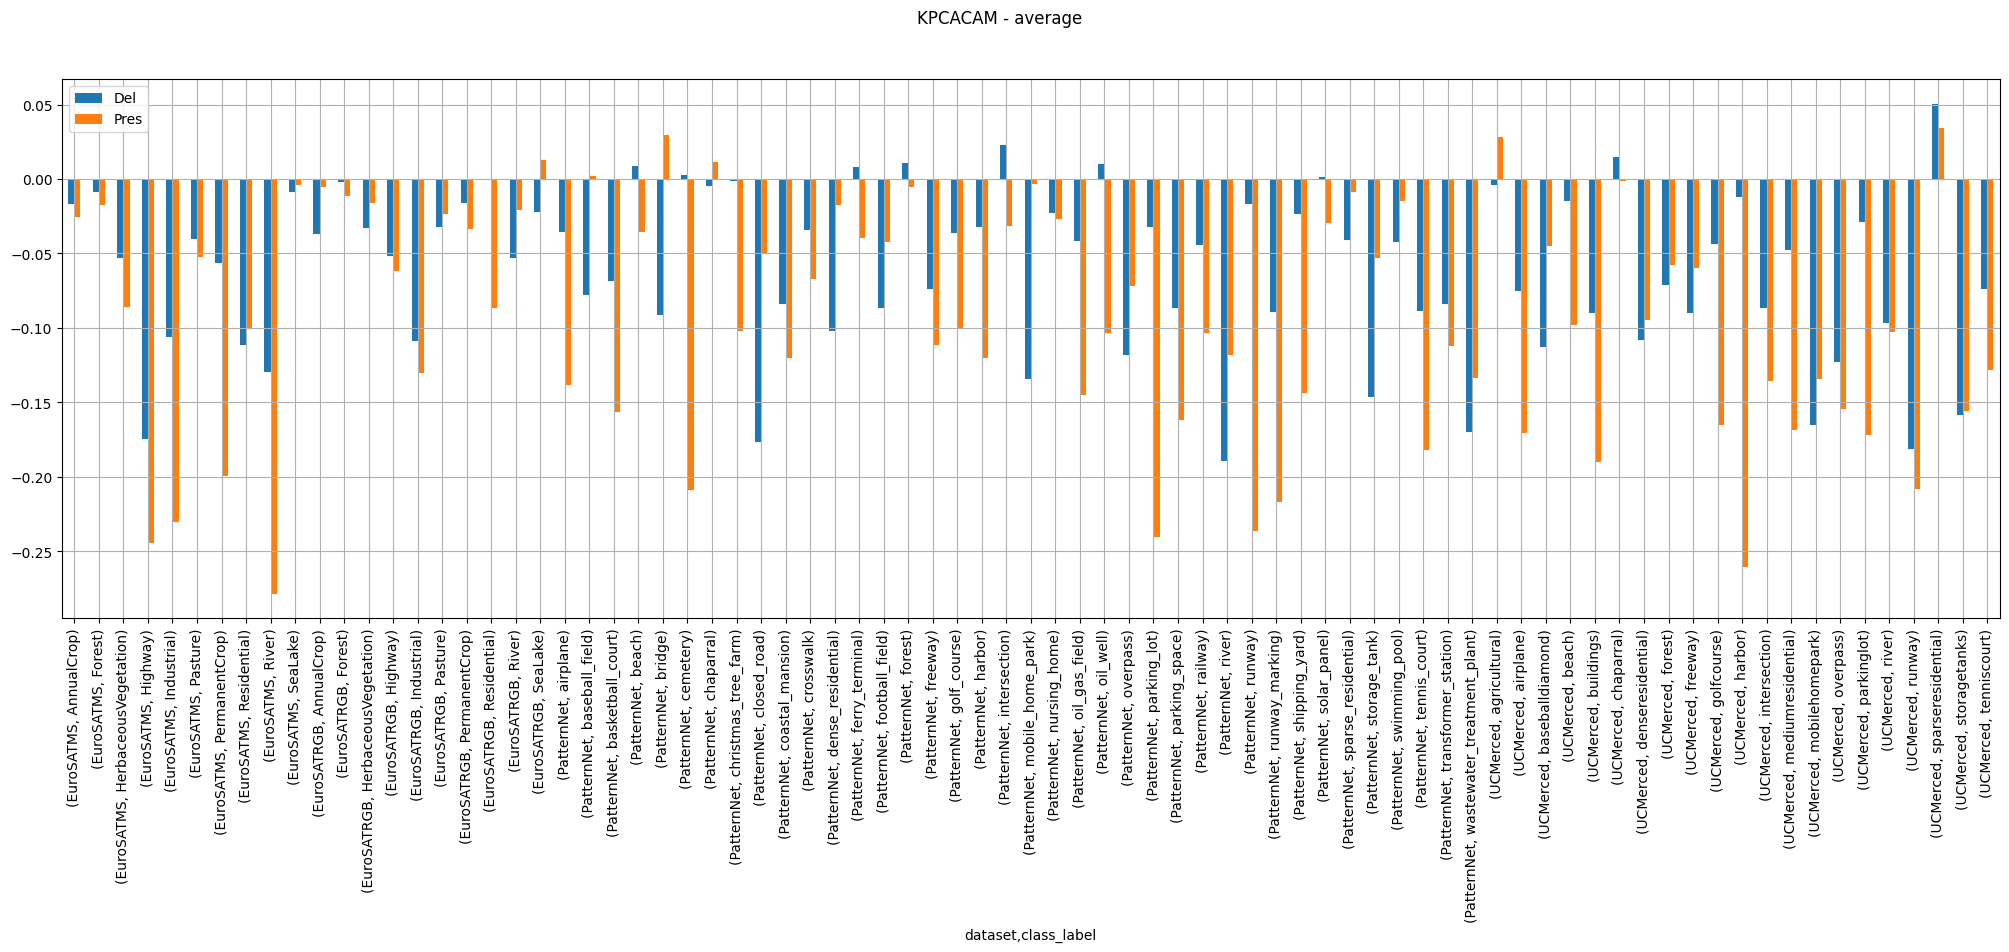

In [149]:
(oc_dp_df.loc["KPCACAM"].groupby(["dataset", "class_label"]).mean() - oc_dp_df_by_class_mean).plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("KPCACAM - average")

KPCACAM is worse than average in virtually every class for both metrics.

Text(0.5, 0.98, 'PartitionSHAP')

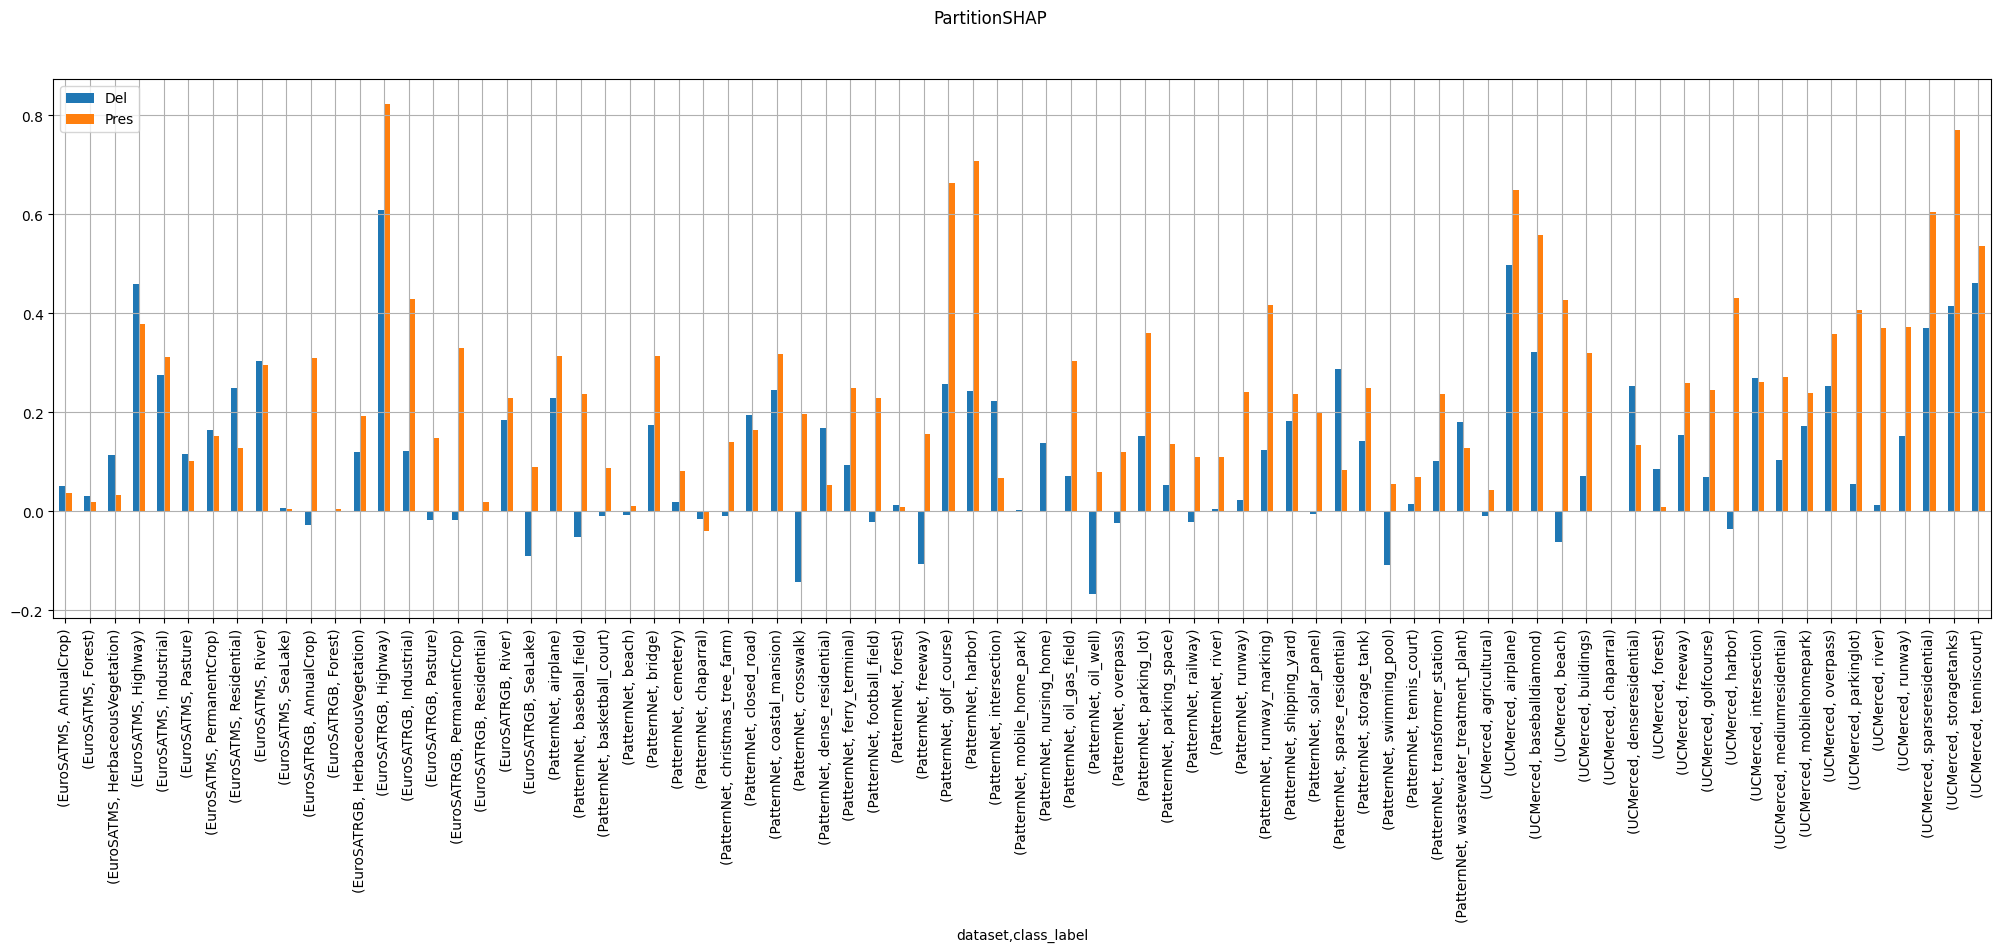

In [150]:
oc_dp_df.loc["PartitionSHAP"].groupby(["dataset", "class_label"]).mean().plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("PartitionSHAP")

PartitionSHAP manages a positive score across almost all classes.

## Explainer efficacy on different models

Text(0.5, 0.98, 'Model robustness')

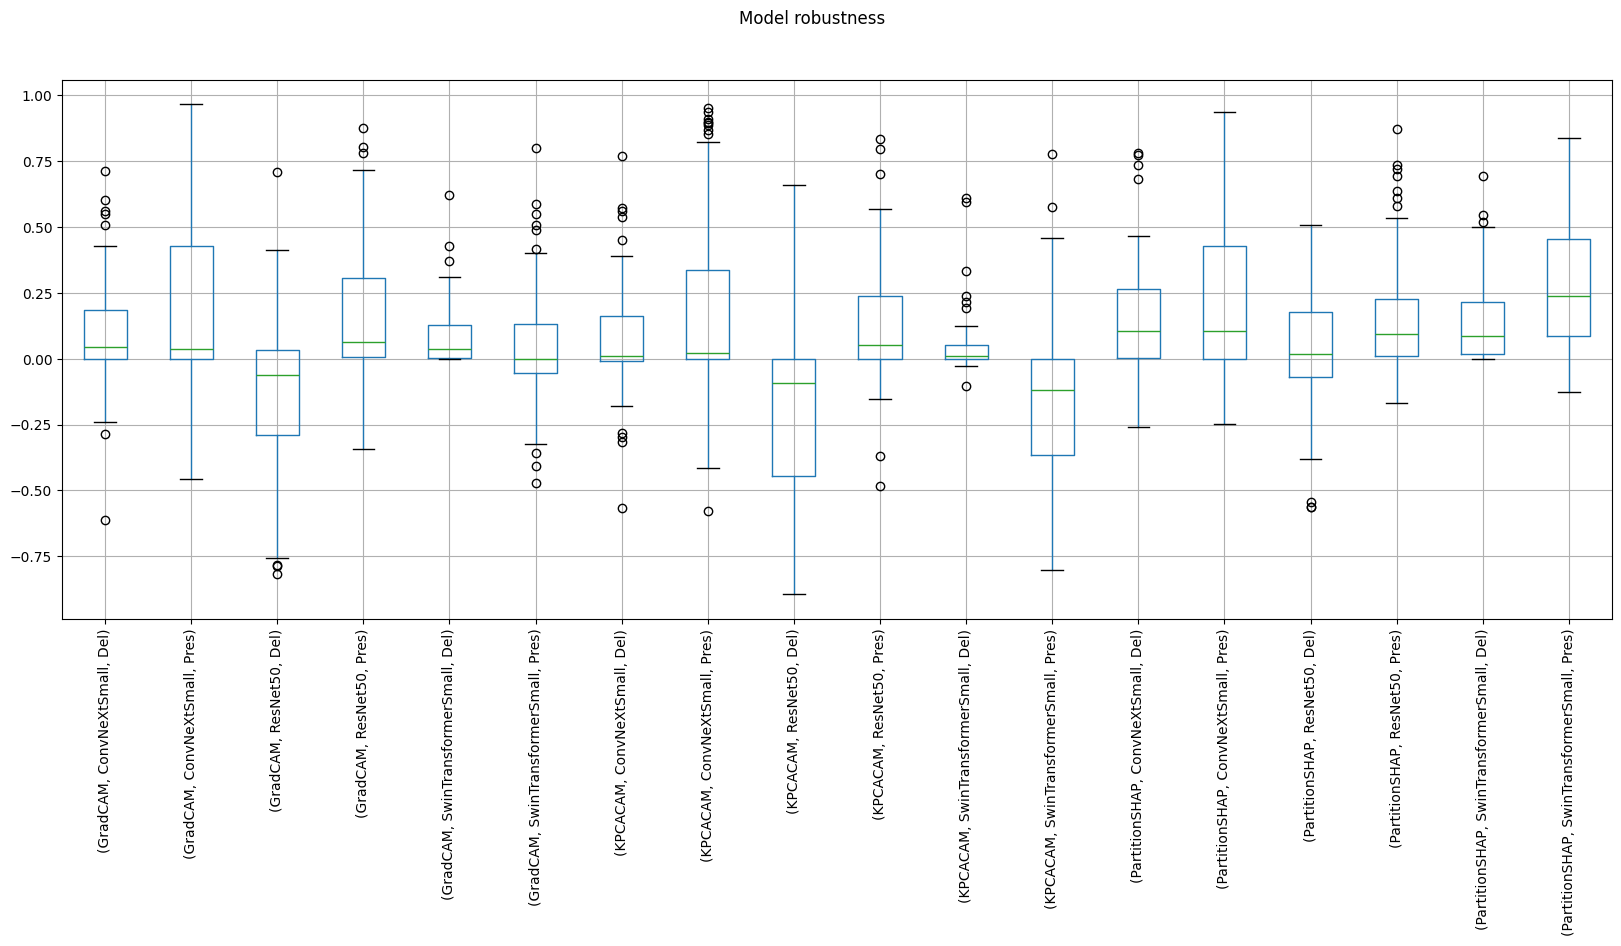

In [118]:
oc_dp_df.groupby(["xai_method", "model"]).boxplot(rot=90, figsize=(20, 7), subplots=False)
plt.suptitle("Model robustness")

Deleting pixels rarely flipped ResNets.

In [126]:
oc_dp_df.groupby(["xai_method", "model"]).describe()

Del                             \
                                   count     mean      std      min   
xai_method    model                                                   
GradCAM       ConvNeXtSmall         79.0  0.09813  0.21005 -0.61278   
              ResNet50              79.0 -0.14403  0.29999 -0.81754   
              SwinTransformerSmall  79.0  0.08381  0.11208 -0.00014   
KPCACAM       ConvNeXtSmall         79.0  0.07359  0.20592 -0.56534   
              ResNet50              79.0 -0.20597  0.31352 -0.89428   
              SwinTransformerSmall  79.0  0.04726  0.10997 -0.10365   
PartitionSHAP ConvNeXtSmall         79.0  0.16419  0.20519 -0.25849   
              ResNet50              79.0  0.02958  0.21782 -0.56401   
              SwinTransformerSmall  79.0  0.14386  0.15928 -0.00013   

                                                                            \
                                            25%      50%      75%      max   
xai_method    model                                                          
GradCAM       ConvNeXtSmall        -1.81212e-03  0.04269  0.18533  0.71167   
              ResNet50             -2.90927e-01 -0.06387  0.03403  0.71002   
              SwinTransformerSmall  4.17697e-03  0.03764  0.12839  0.62235   
KPCACAM       ConvNeXtSmall        -7.66703e-03  0.00837  0.16274  0.77114   
              ResNet50             -4.45328e-01 -0.09306 -0.00026  0.66023   
              SwinTransformerSmall  1.08033e-07  0.00886  0.05168  0.61063   
PartitionSHAP ConvNeXtSmall         3.46779e-03  0.10417  0.26383  0.77958   
              ResNet50             -7.08983e-02  0.01746  0.17627  0.50657   
              SwinTransformerSmall  1.73575e-02  0.08446  0.21570  0.69325   

                                    Pres                             \
                                   count     mean      std      min   
xai_method    model                                                   
GradCAM       ConvNeXtSmall         79.0  0.22697  0.35397 -0.45732   
              ResNet50              79.0  0.16682  0.23844 -0.34340   
              SwinTransformerSmall  79.0  0.04113  0.22976 -0.47041   
KPCACAM       ConvNeXtSmall         79.0  0.18528  0.33876 -0.57787   
              ResNet50              79.0  0.13046  0.22553 -0.48505   
              SwinTransformerSmall  79.0 -0.17442  0.30012 -0.80272   
PartitionSHAP ConvNeXtSmall         79.0  0.25389  0.31882 -0.24879   
              ResNet50              79.0  0.16312  0.21738 -0.16676   
              SwinTransformerSmall  79.0  0.28084  0.23796 -0.12596   

                                                                           \
                                            25%          50%          75%   
xai_method    model                                                         
GradCAM       ConvNeXtSmall         3.62396e-05  3.66099e-02  4.29130e-01   
              ResNet50              5.57780e-03  6.36860e-02  3.06990e-01   
              SwinTransformerSmall -5.46895e-02 -4.17233e-06  1.31207e-01   
KPCACAM       ConvNeXtSmall         5.96046e-08  2.11669e-02  3.36318e-01   
              ResNet50              1.55628e-04  5.35928e-02  2.36628e-01   
              SwinTransformerSmall -3.66612e-01 -1.17630e-01  3.03984e-06   
PartitionSHAP ConvNeXtSmall         1.88887e-04  1.05637e-01  4.26490e-01   
              ResNet50              1.13874e-02  9.43065e-02  2.28054e-01   
              SwinTransformerSmall  8.80092e-02  2.37946e-01  4.52898e-01   

                                             
                                        max  
xai_method    model                          
GradCAM       ConvNeXtSmall         0.96664  
              ResNet50              0.87618  
              SwinTransformerSmall  0.80123  
KPCACAM       ConvNeXtSmall         0.95191  
              ResNet50              0.83364  
              SwinTransformerSmall  0.77843  
PartitionSHAP ConvNeXtSmall         0.93796  
         

ResNet explanations are very difficult to delete from. SwinTransformer is hard to preserve for CAM methods. ConvNeXt somewhat explainable by all and for specific classes can do very well.

### For specific datasets

<Axes: xlabel='xai_method,class_label'>

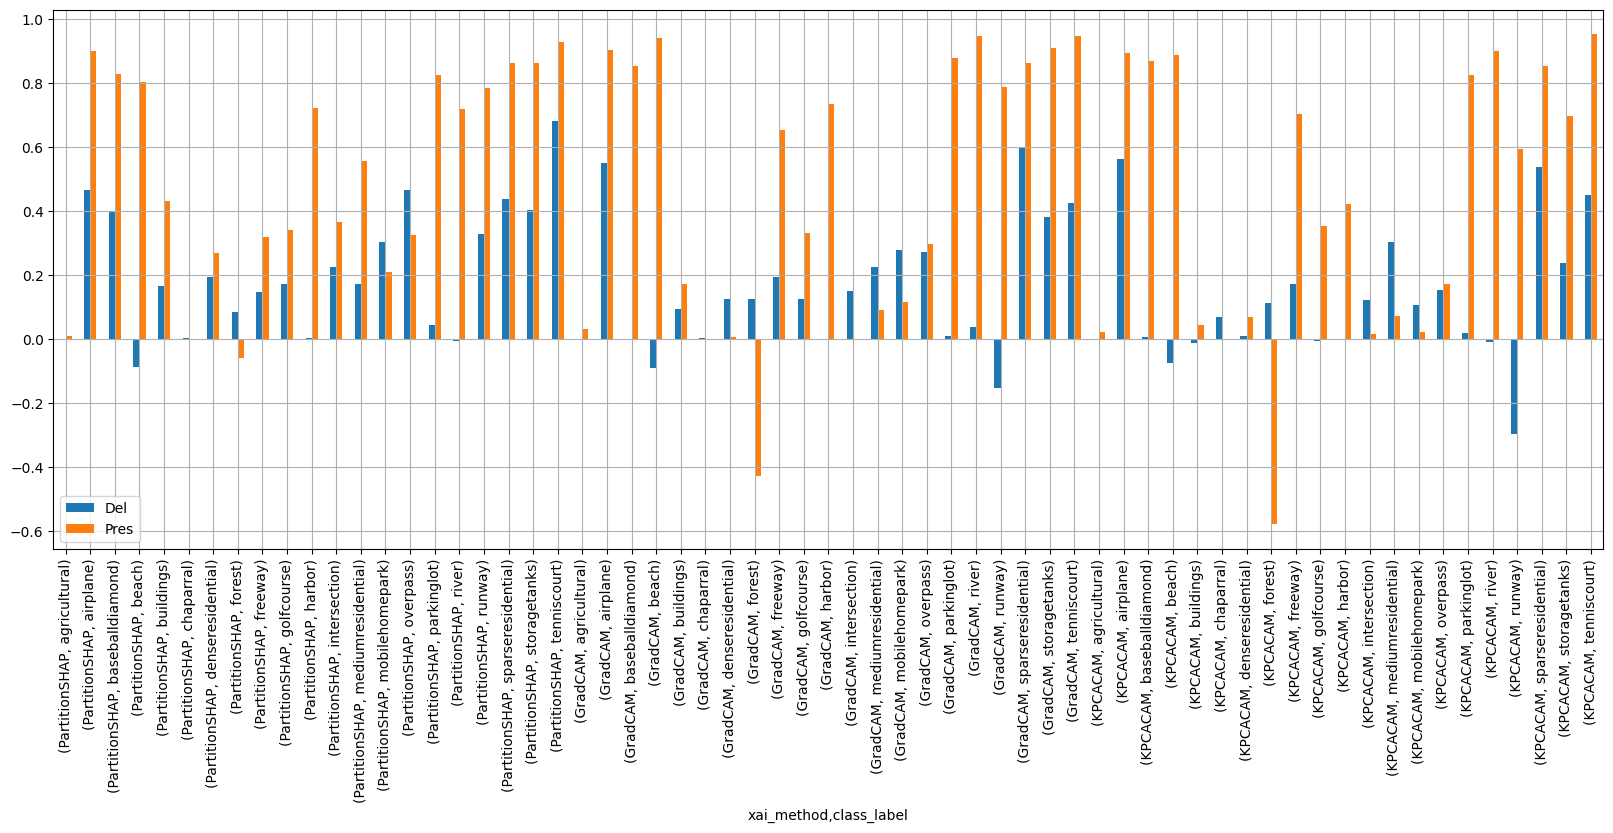

In [164]:
oc_dp_df.loc[:, "UCMerced", "ConvNeXtSmall"].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True)

The same classes are consistently difficult across all explanation methods. For some specific classes, all methods are successful at identifying important (e.g. PatternNet tennis court)

model
ConvNeXtSmall           Axes(0.125,0.11;...
ResNet50                Axes(0.125,0.11;...
SwinTransformerSmall    Axes(0.125,0.11;...
dtype: object

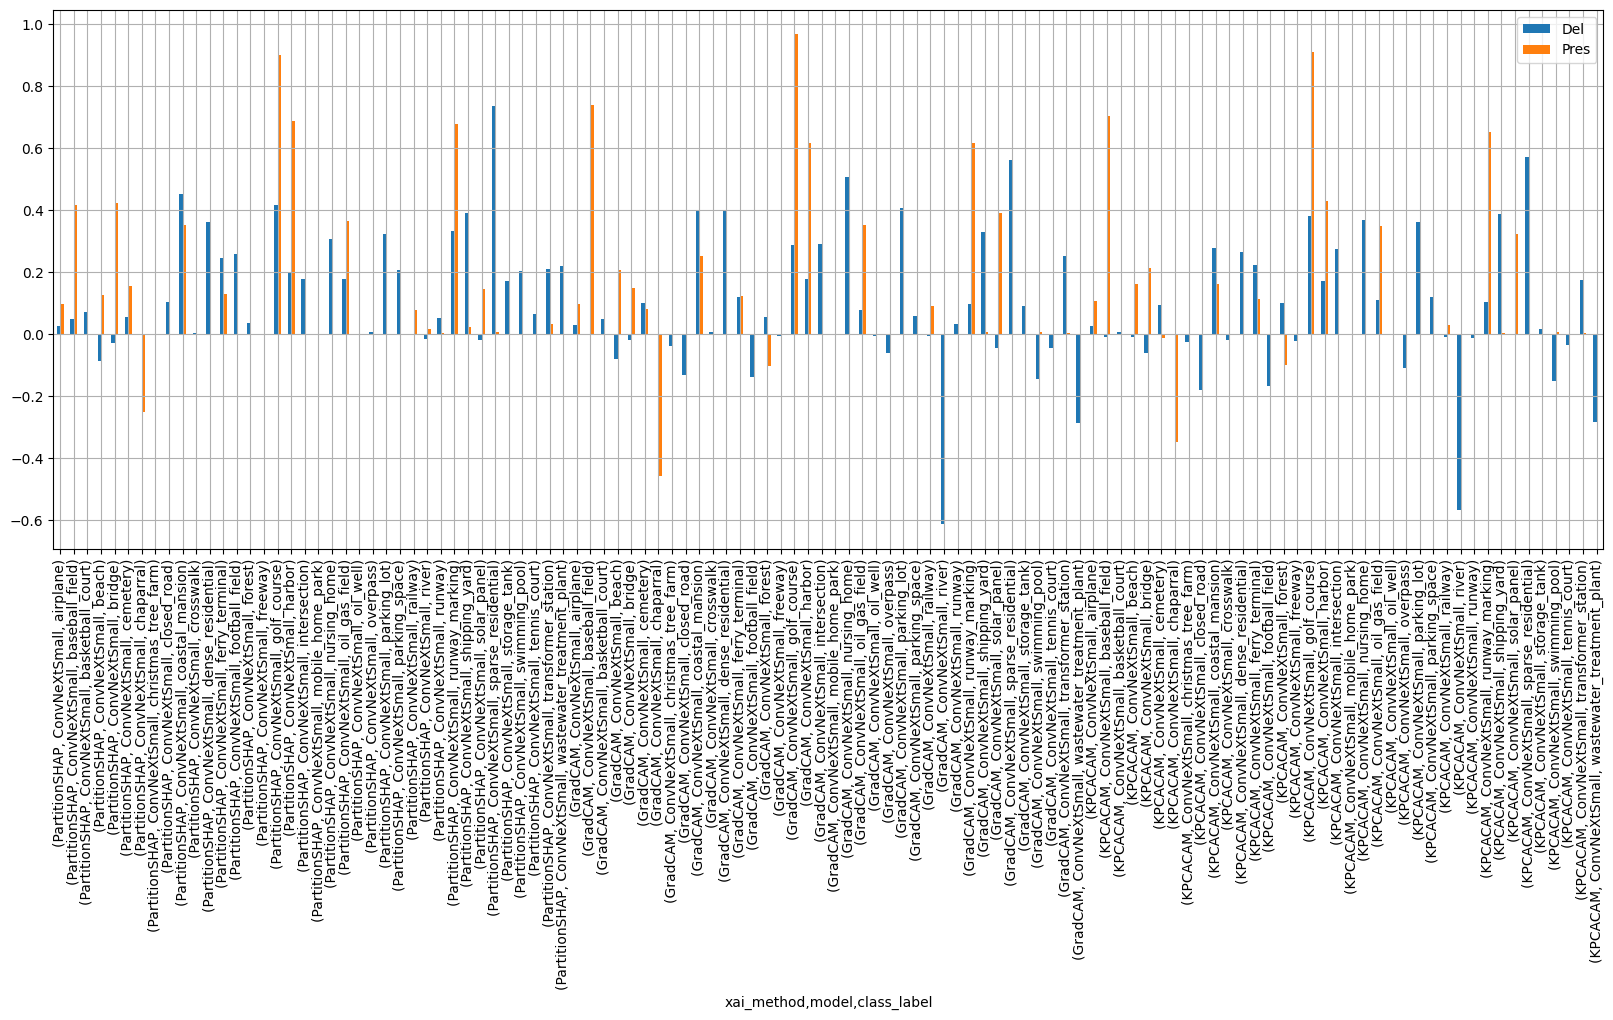

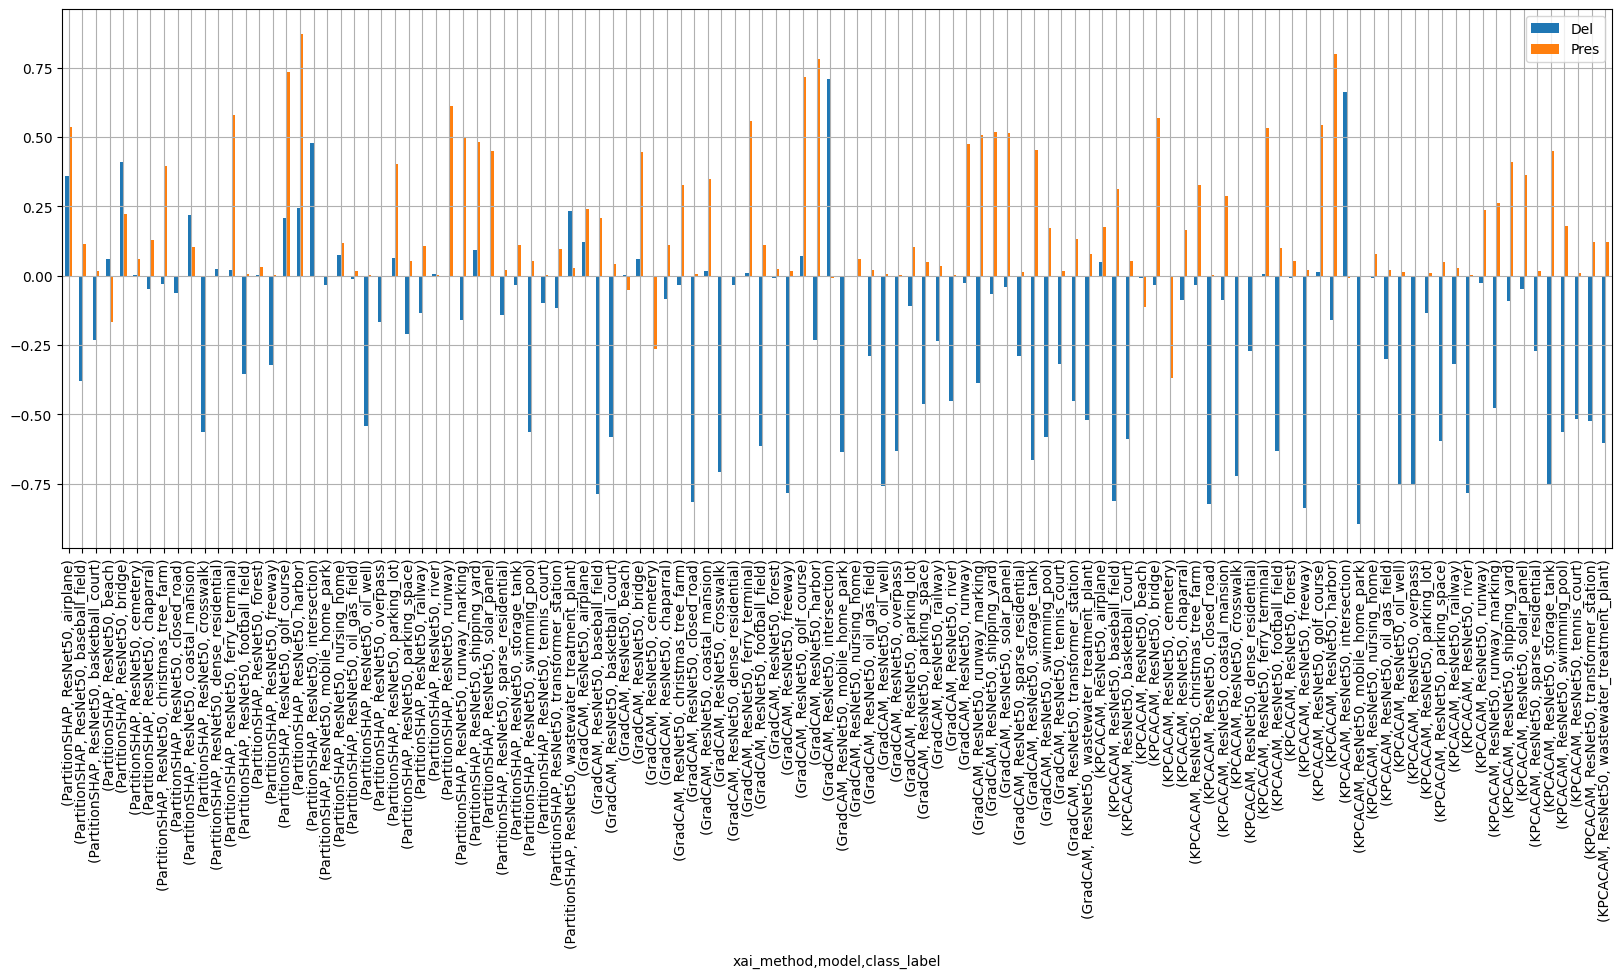

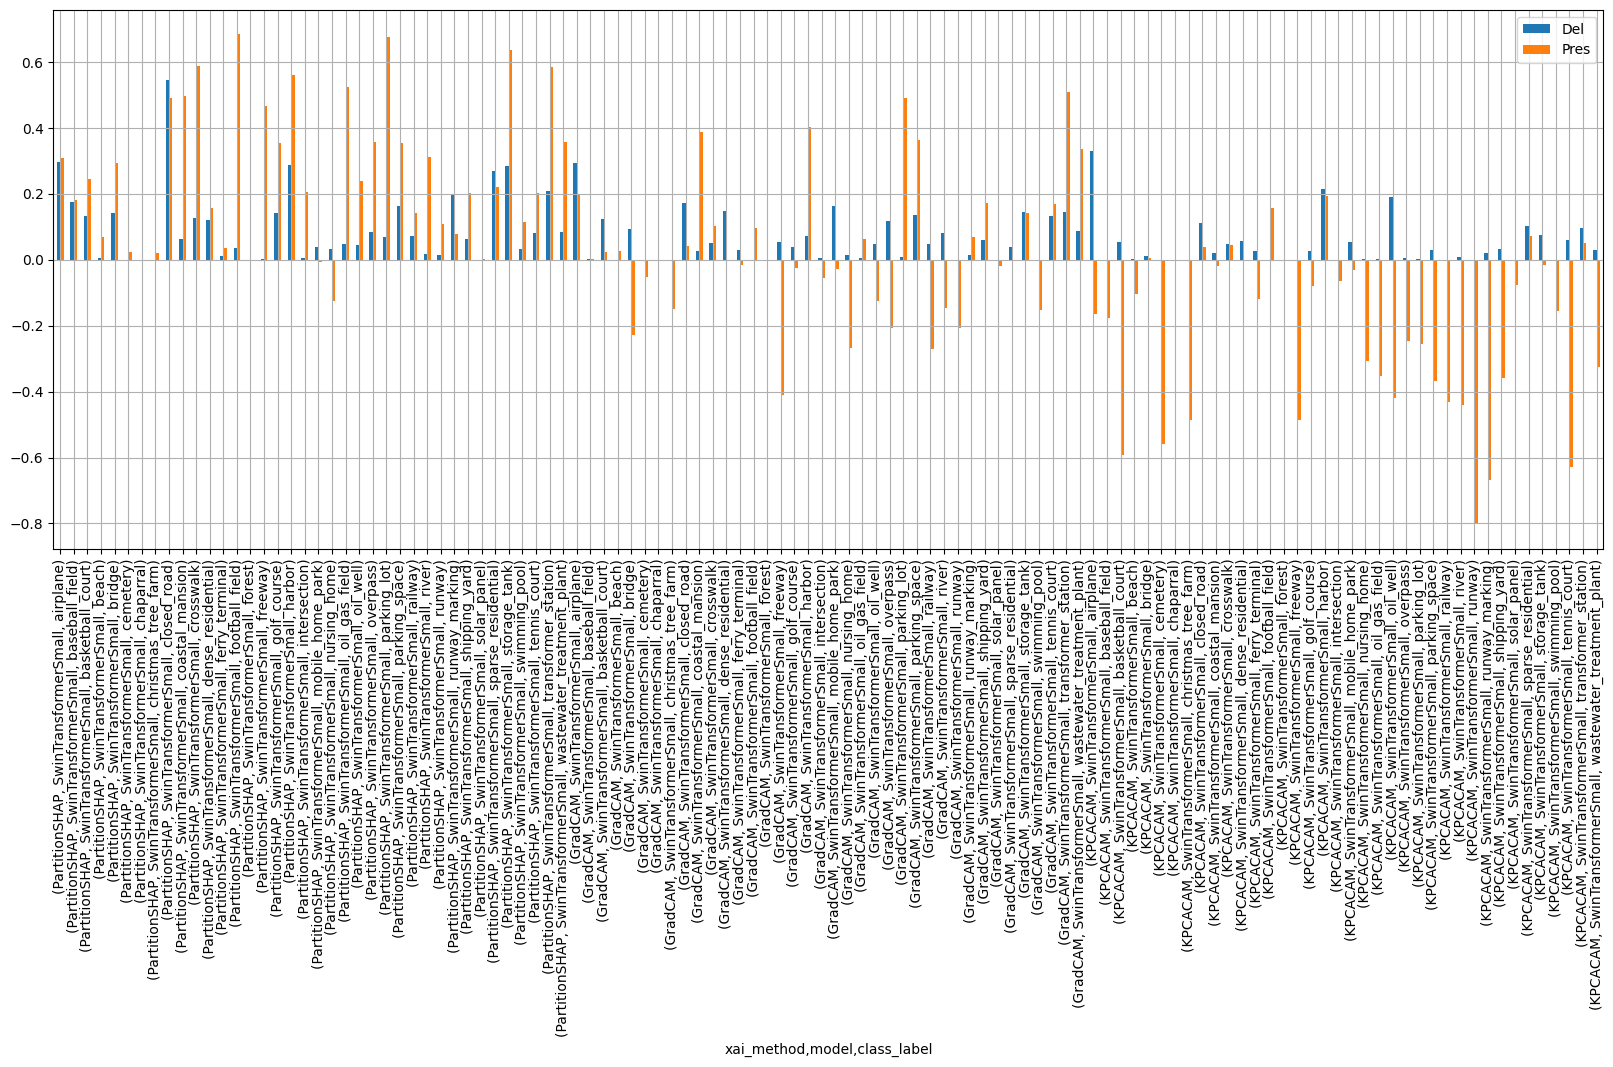

In [167]:
oc_dp_df.loc[:, "PatternNet", :].groupby("model").plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True)

For PatternNet, best explanations are for ConvNeXt across all explainers. KPCA struggles to preserve the correct areas for the SwinTransformer.

model
ConvNeXtSmall           Axes(0.125,0.11;...
ResNet50                Axes(0.125,0.11;...
SwinTransformerSmall    Axes(0.125,0.11;...
dtype: object

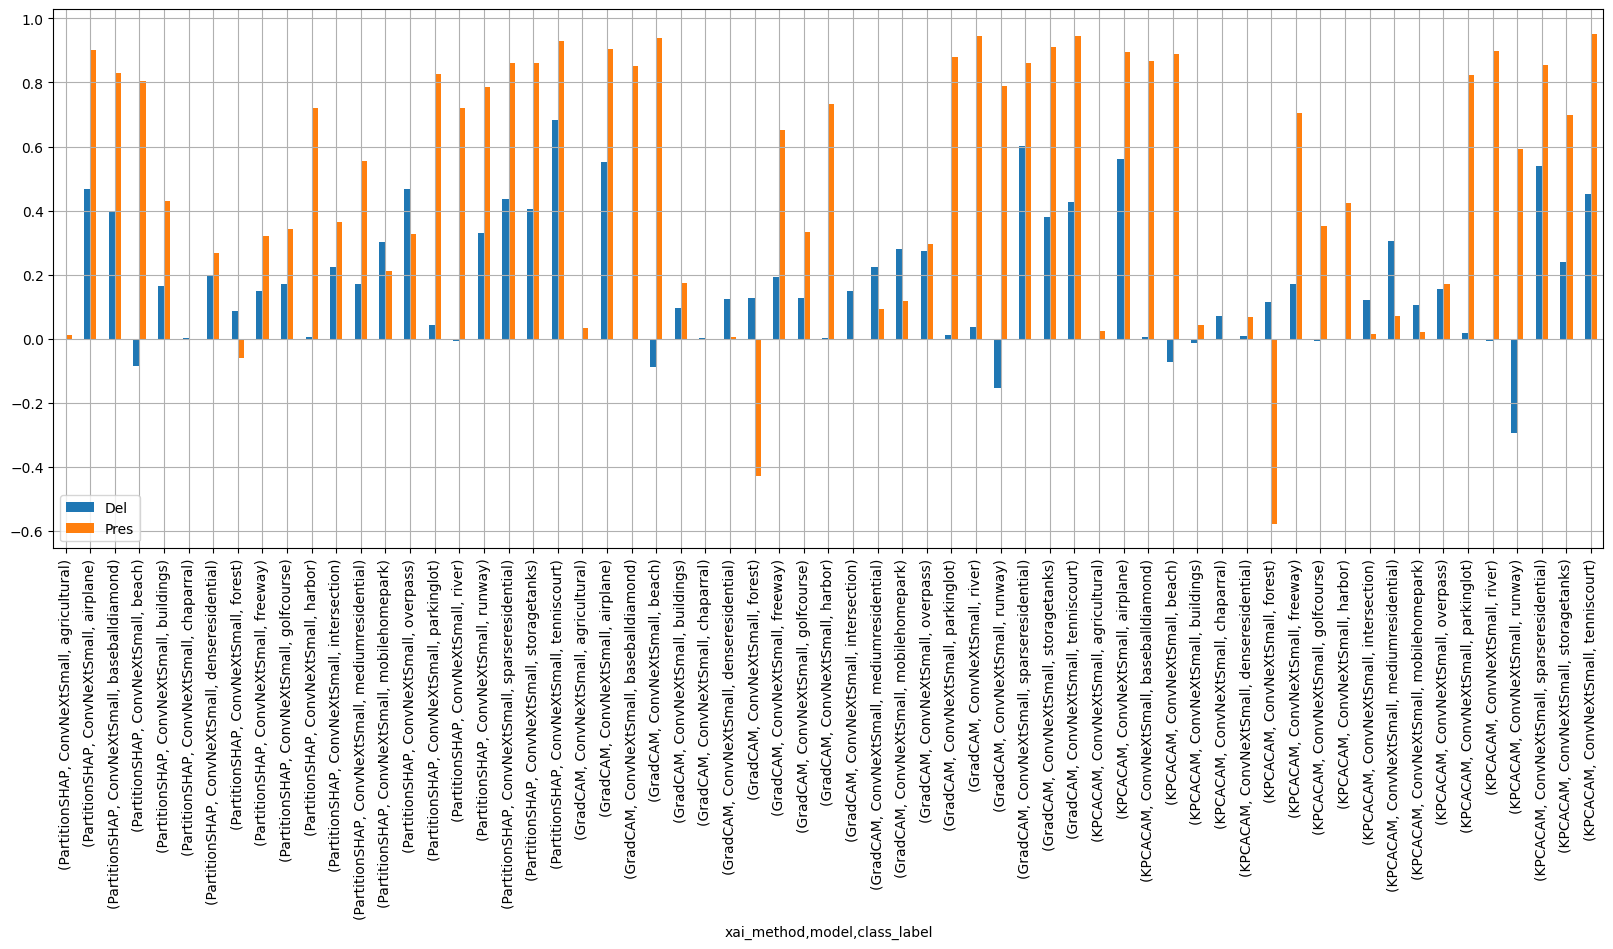

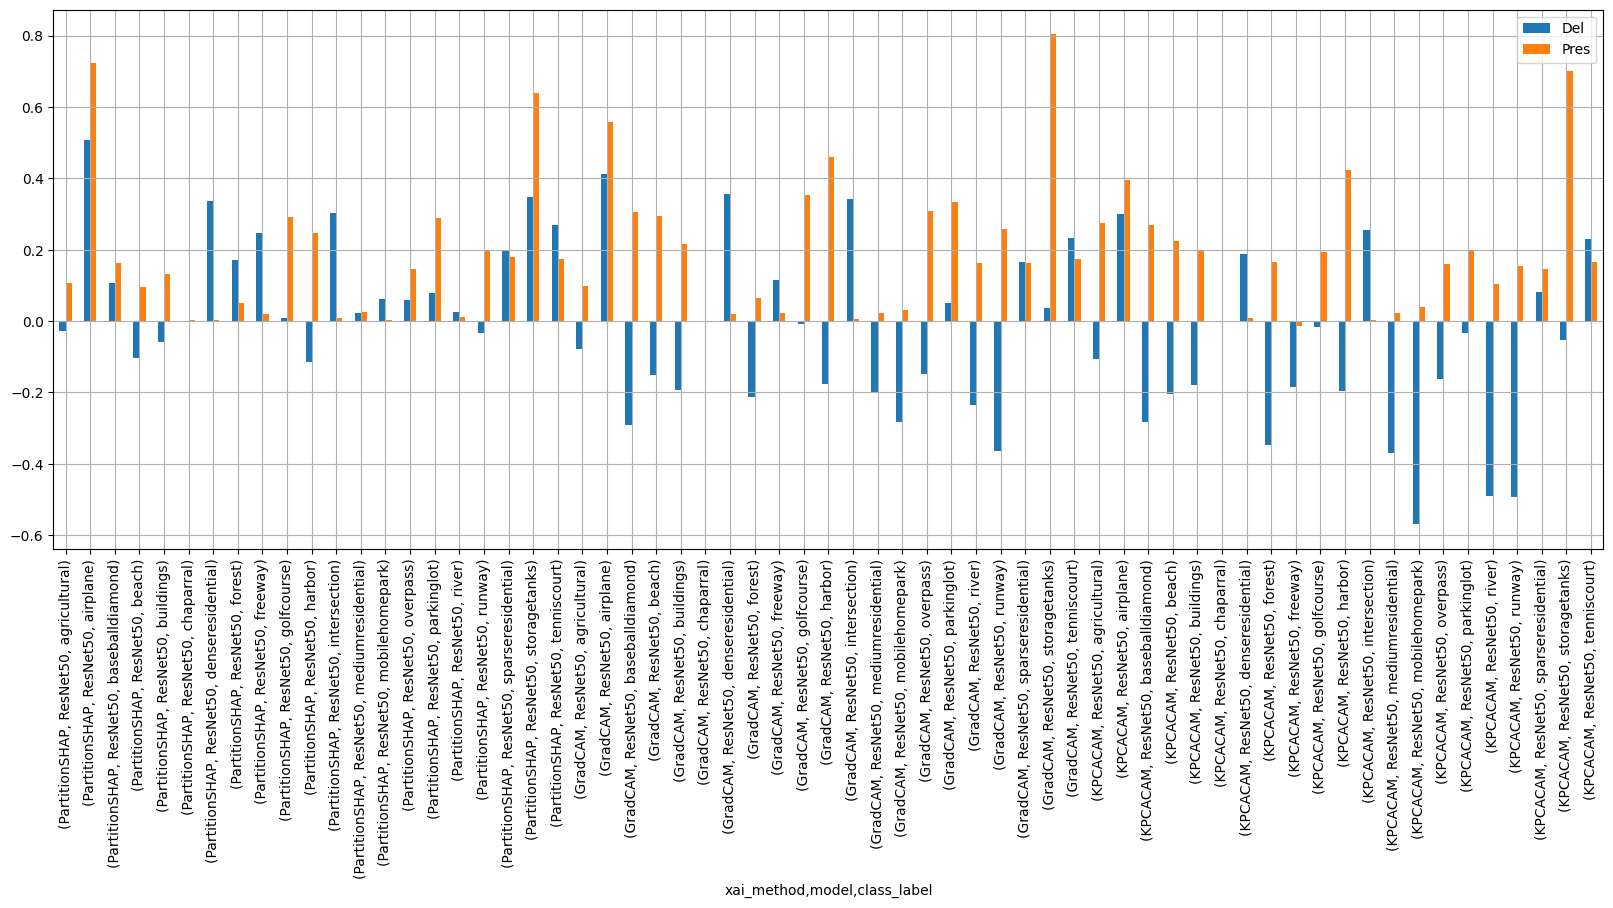

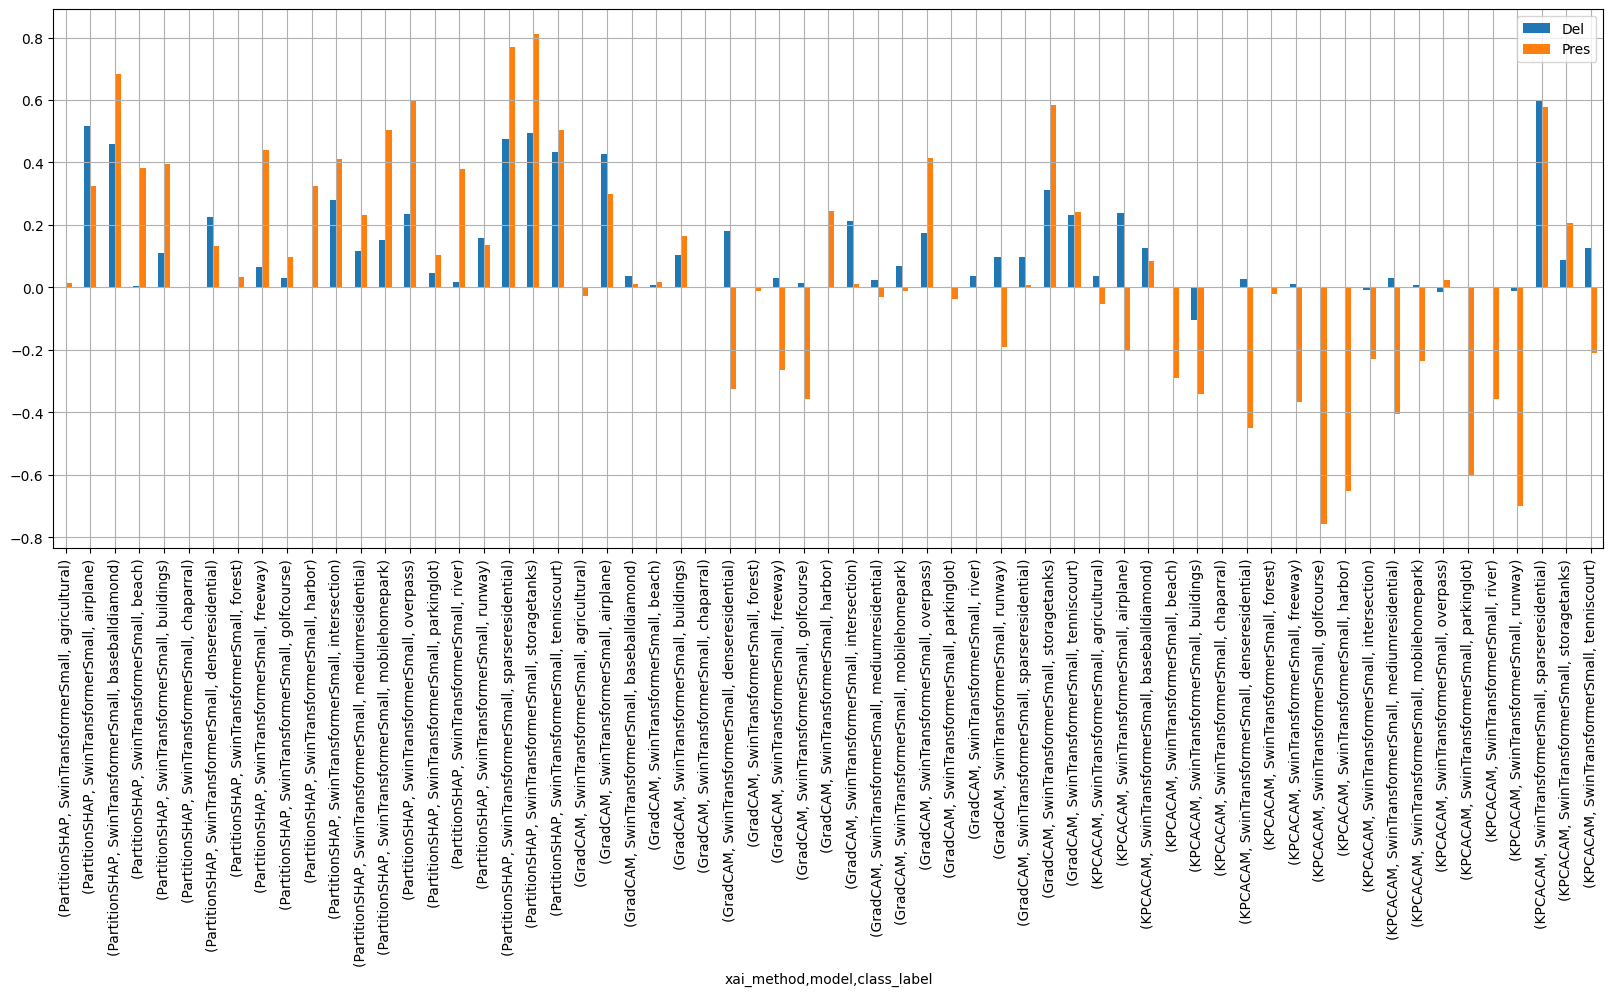

In [168]:
oc_dp_df.loc[:, "UCMerced", :].groupby("model").plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True)

For UCMerced again, ConvNeXt easiest to explain. CAM methods struggle to delete from ResNet (small convolutions make it sensitive to small regions changing?). KPCACAM can't preserve for SwinT (large attention based tokens mean it considers the whole image?)